In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, classification_report, confusion_matrix
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import chi2
from scipy.stats import norm
from scipy.stats import mannwhitneyu
from scipy.stats import ranksums
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import matplotlib.pyplot as plt 
import matplotlib.mlab as mlab
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from dbfread import DBF
import plotly.express as px
from plotly import graph_objects as go
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from collections import Counter
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from numpy import mean
import imblearn
import re
import warnings
warnings.filterwarnings('ignore')

## TABLE OF CONTENTS

1. [Data Cleaning](#clean)
2. [Indicator 6](#ind6)
3. [Indicator 8](#ind8)
4. [Indicator 9](#ind9)
5. [Indicator 3](#ind3)
6. [Indicator 63](#ind63)
7. [Machine Learning - Linear Regression](#lr)
8. [Machine Learning - Logistic Regression](#lor)

## Data Cleaning <a id='clean'> 

In [2]:
pca191 = pd.read_csv("2019pCA1.csv")
hca191 = pd.read_csv("2019hCA1.csv")

In [3]:
def cleanData(person_df, household_df, post2018 = True):
    person_df = person_df
    household_df = household_df
    pFeatures = ["SERIALNO", "SPORDER", "PUMA", "PWGTP", "AGEP", "CIT", "COW", "ENG", "FER", "JWMNP"
               , "MAR", "MIL", "SCH", "SCHL", "SEX", "PAP", "INTP", "SSIP", "SSP", "WAGP"
               , "OIP", "RETP", "SEMP", "PERNP", "PINCP", "WKL", "DIS", "ESR", "HICOV", "HISP"
               , "PAOC", "POVPIP", "RAC1P", "RACASN", "RACBLK", "RACWHT", "RACSOR", "SCIENGP", "WKHP"
               , "SOCP"]
    if post2018:
        pFeatures = pFeatures + ["RELSHIPP", "JWTRNS", "WKWN"]
    else:
        pFeatures = pFeatures + ["RELP", "JWTR", "WKW"]
    hFeatures = ["SERIALNO", "PUMA", "NP", "ACCESS", "ACR", "BATH", "FS", "ELEP", "FULP", "GASP", "HISPEED"
              , "LAPTOP", "RNTP", "RWATPR", "TEN", "VALP", "VEH", "WATP", "HINCP", "HUPAC", "KIT", "PLM"
              , "GRPIP", "RMSP"]
    person_df = person_df.loc[:, pFeatures].copy()
    household_df = household_df.loc[:, hFeatures].copy()
    person_df = person_df.loc[(person_df["PUMA"] > 101) & (person_df["PUMA"] <= 105)].copy()
    household_df = household_df.loc[(household_df["PUMA"] > 101) & (household_df["PUMA"] <= 105)].copy()
    person_df.loc[(person_df.RAC1P == 1) & (person_df.HISP == 1), "RACE"] = "White"
    person_df.loc[(person_df.RAC1P == 2) & (person_df.HISP == 1), "RACE"] = "African American"
    person_df.loc[(person_df.RAC1P == 6) & (person_df.HISP == 1), "RACE"] = "Asian"
    person_df.loc[(person_df.RAC1P.isin([3, 4, 5, 7, 8, 9])) & (person_df.HISP == 1), "RACE"] = "Other"
    person_df.loc[person_df.HISP != 1, "RACE"] = "Latino"
    person_df = person_df.merge(household_df, how = 'left', on = 'SERIALNO').copy()
    person_df = person_df.reindex(person_df.index.repeat(person_df.PWGTP)).reset_index(drop=True).drop(['PWGTP', 'PUMA_y'], axis=1).rename(columns={"PUMA_x": "PUMA"}).copy()
    return person_df

In [4]:
pca191_Ok = cleanData(pca191, hca191)

## Unemployment rate<a id='ind6'>

## Ind6 function

In [5]:
def ind6_2019(df):
    va_unem = ["RACE", "AGEP", "SEX", "COW", "FER", "MAR", "PAOC", "MIL", "ESR", "RETP"]
    df_unem = df[va_unem]
    # less than 16 is not counted as labor force.
    df_unem1 = df_unem[df_unem.AGEP >= 16]
    # category 6 means not in labor force.
    df_unem2 = df_unem1[df_unem1.ESR != 6]
    df_unem2.dropna(subset=['ESR'])
    # in ESR variables, there are 6 category. number 3 only means unemployment so, change others to one value.
    change_unem = {1:1, 2:1, 3:0, 4:1, 5:1}
    df_unem2["ESR"] = df_unem2["ESR"].map(change_unem)
    # select only white, black, and asian because others data is not enough.
    df_unem3 = df_unem2[(df_unem2.RACE == 'White') | (df_unem2.RACE == 'African American') | (df_unem2.RACE == 'Asian') | (df_unem2.RACE == 'Latino') | (df_unem2.RACE == 'Other')]
    df_unem3.dropna(subset=['RACE'])
    df_unemgroup = df_unem3.groupby(["RACE"])["ESR"].mean()
    df_unemgroup = df_unemgroup.to_frame()
    df_unemgroup['UnemploymentRate%']  = (1 - df_unemgroup.ESR)*100
    df_unemgroup = df_unemgroup.drop(columns=['ESR'])
    df_unemgroup_total = df_unemgroup["UnemploymentRate%"].sum()
    df_unemgroup.loc[len(df_unemgroup)] = [df_unemgroup_total]
    df_unemgroup = df_unemgroup.reset_index()
    df_unemgroup.loc[len(df_unemgroup)-1, "RACE"] = "Total"
    df_unemgroup["UnemploymentRate%"] = df_unemgroup["UnemploymentRate%"].round(3)
    unem_black = df_unemgroup.loc[df_unemgroup['RACE'] == 'African American', 'UnemploymentRate%'].iloc[0]
    unem_white = df_unemgroup.loc[df_unemgroup['RACE'] == 'White', 'UnemploymentRate%'].iloc[0]
    unem_ratio = unem_black / unem_white
    ind6_result = print(f'Unemployment Ratio = {round(unem_ratio, 3)}')
    return df_unemgroup, ind6_result, df_unem3

In [6]:
indi6 = ind6_2019(pca191_Ok)
df_unemgroup = indi6[0]
df_unem3 = indi6[2]

Unemployment Ratio = 2.502


## Ratio/Score Black-to-White Unemployment rate

In [7]:
unem_black = df_unemgroup.loc[df_unemgroup['RACE'] == 'African American', 'UnemploymentRate%'].iloc[0]
unem_white = df_unemgroup.loc[df_unemgroup['RACE'] == 'White', 'UnemploymentRate%'].iloc[0]
unem_asian = df_unemgroup.loc[df_unemgroup['RACE'] == 'Asian', 'UnemploymentRate%'].iloc[0]
unem_latino = df_unemgroup.loc[df_unemgroup['RACE'] == 'Latino', 'UnemploymentRate%'].iloc[0]
unem_ratio = unem_black / unem_white
print(f'black unemployment rate = {round(unem_black,2)}%')
print(f'white unemployment rate = {round(unem_white,2)}%')
print(f'asian unemployment rate = {round(unem_asian,2)}%')
print(f'latino unemployment rate = {round(unem_latino,2)}%')
print(f'Unemployment Ratio = {round(unem_ratio, 3)}')
print('Unemployment Score = 37')

black unemployment rate = 8.17%
white unemployment rate = 3.27%
asian unemployment rate = 3.53%
latino unemployment rate = 4.19%
Unemployment Ratio = 2.502
Unemployment Score = 37


In [8]:
df_unemgroup["UnemploymentRate%"] = indi6[0]["UnemploymentRate%"].round(2)
x = df_unemgroup["RACE"]
y = df_unemgroup["UnemploymentRate%"]

In [9]:
# select only race and unemployment variable.
df_unem4 = df_unem3[["RACE", "ESR"]]
race = ['African American', 'White', 'Asian', 'Latino', 'Other']
race_list = []
for i in race:
    dd = df_unem4[(df_unem4.RACE == i)]
    race_list.append(dd["ESR"].value_counts().tolist())

# making crosstable
unem_mat = pd.DataFrame(list(zip(race_list[0], race_list[1], race_list[2], race_list[3], race_list[4])), columns = race)
b, c = unem_mat.iloc[0].copy(), unem_mat.iloc[1].copy()
unem_mat.iloc[0], unem_mat.iloc[1] = c, b
unem_mat

,African American,White,Asian,Latino,Other
0,4863,3962,2553,3421,885
1,54659,117365,69832,78149,17926


In [10]:
# change to percentage
for i in unem_mat.columns:
    unem_mat[(f'{i}%')] = round((unem_mat[i] / unem_mat[i].sum()) * 100, 2)
unem_mat_percent = unem_mat.drop(columns = ["African American", "White", "Asian", "Latino", "Other"])
unem_mat_percent

,African American%,White%,Asian%,Latino%,Other%
0,8.17,3.27,3.53,4.19,4.7
1,91.83,96.73,96.47,95.81,95.3


In [11]:
recolumns = ["African American%", "Other%", "Latino%", "Asian%", "White%"]
unem_mat_percent = unem_mat_percent.reindex(columns = recolumns)

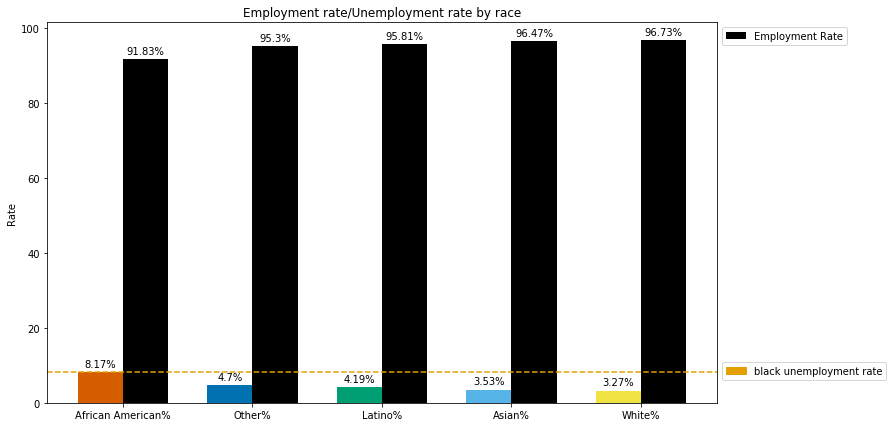

In [12]:
labels = unem_mat_percent.columns.tolist()
unem_per = unem_mat_percent.iloc[0,:].values.tolist()
em_per = unem_mat_percent.iloc[1,:].values.tolist()
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots(figsize = (12,7))
bar1 = ax.bar(x - width/2, unem_per, width, label = "Unemployment Rate", color = "#F0E442")
bar2 = ax.bar(x + width/2, em_per, width, label = "Employment Rate", color = "black")
bar1[0].set_color('#D55E00')
bar1[1].set_color('#0072B2')
bar1[2].set_color('#009E73')
bar1[3].set_color('#56B4E9')
bar1[4].set_color('#F0E442')
ax.set_ylabel("Rate")
ax.set_title("Employment rate/Unemployment rate by race")
ax.set_xticks(x)
ax.set_xticklabels(labels)
leg = ax.legend(handles=[bar2], bbox_to_anchor=(1.0, 1))

def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(str('{}'.format(height)+"%"),
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext = (0, 3),
                    textcoords = "offset points",
                    ha = "center", va = "bottom")
        
plt.axhline(y = 8.17, color = '#E69F00', linestyle = '--')
line_legend = mpatches.Patch(color = '#E69F00', label = 'black unemployment rate')
plt.legend(handles = [line_legend], bbox_to_anchor = (1.0, 0.12), loc = 'upper left')
ax.add_artist(leg)
autolabel(bar1)
autolabel(bar2)
plt.show()

Black unemployment rate is clearly much higher than white and asian unemployment rate.

In [13]:
unem_table = pd.crosstab(df_unem3["RACE"], df_unem3["ESR"])
observed_values = unem_table.values
unem_test = stats.chi2_contingency(unem_table)
expected_values = unem_test[3]
no_rows = len(unem_table)
no_cols = len(unem_table.columns)
ddof = (no_rows - 1) * (no_cols - 1)
from scipy.stats import chi2
chi_square = sum([(x - y)**2./y for x,y in zip(observed_values,expected_values)])
chi_square_statistic = chi_square[0] + chi_square[1]
alpha = 0.05
p_value = 1 - chi2.cdf(x=  chi_square_statistic,df = ddof)
print('p-value:',p_value)
print("alpha = 0.05")
if p_value > alpha:
    print('Fail to reject H0: There is no relationship between 2 categorical variables')
else:
    print('Reject H0: There is a relationship between 2 categorical variables')

p-value: 0.0
alpha = 0.05
Reject H0: There is a relationship between 2 categorical variables


In [14]:
mod = ols('ESR ~ RACE', data = df_unem3).fit()
mod_table = sm.stats.anova_lm(mod, typ = 2)
print(mod_table)

                sum_sq        df           F  PR(>F)
RACE        106.210189       4.0  630.906471     0.0
Residual  14882.152307  353610.0         NaN     NaN


Race and Unemployment variables are significantly associated. Changing a category in one variable might change another variable. For example, change the race for white to black, employment stats might change too.

## Median household income <a id='ind8'> 

## Ind8 function

In [15]:
def ind8_2019(df):
    df_merge1 = df[df.HINCP > 1]
    df_merge2 = df_merge1[df_merge1.RELSHIPP  == 20]
    inc = ["RACE", "HINCP"]
    df_inc = df_merge2[inc]
    # select only white, black, and asian.
    df_inc1 = df_inc[(df_inc.RACE == 'White') | (df_inc.RACE == 'African American') | (df_inc.RACE == 'Asian') | (df_inc.RACE == 'Latino') | (df_inc.RACE == 'Other')]
    df_inc2 = df_inc1.dropna(subset=['HINCP'])
    # find the median of each race.
    df_incgroup = df_inc2.groupby(["RACE"])["HINCP"].median().to_frame()
    df_incgroup_total = df_inc2.HINCP.median()
    df_incgroup.loc[len(df_incgroup)] = [df_incgroup_total]
    df_incgroup = df_incgroup.reset_index()
    df_incgroup.loc[len(df_incgroup) - 1, "RACE"] = "Total"
    inc_black = df_incgroup.loc[df_incgroup['RACE'] == 'African American', 'HINCP'].iloc[0]
    inc_white = df_incgroup.loc[df_incgroup['RACE'] == 'White', 'HINCP'].iloc[0]
    inc_ratio = inc_white / inc_black
    ind8_result = print(f'Income Ratio = {round(inc_ratio, 3)}')
    return df_incgroup, ind8_result, df_inc2

In [16]:
indi8 = ind8_2019(pca191_Ok)
df_incgroup = indi8[0]

Income Ratio = 2.811


## Ratio/Score Black-to-White Median household income

In [17]:
inc_black = df_incgroup.loc[df_incgroup['RACE'] == 'African American', 'HINCP'].iloc[0]
inc_white = df_incgroup.loc[df_incgroup['RACE'] == 'White', 'HINCP'].iloc[0]
inc_asian = df_incgroup.loc[df_incgroup['RACE'] == 'Asian', 'HINCP'].iloc[0]
inc_latino = df_incgroup.loc[df_incgroup['RACE'] == 'Latino', 'HINCP'].iloc[0]
inc_ratio = inc_white / inc_black
print(f'black median income = {round(inc_black,2)}$')
print(f'white median income = {round(inc_white,2)}$')
print(f'asian median income = {round(inc_asian,2)}$')
print(f'latino median income = {round(inc_latino,2)}$')
print(f'Income Ratio = {round(inc_ratio, 3)}')
print('Income Score = 35')

black median income = 43400.0$
white median income = 122000.0$
asian median income = 87500.0$
latino median income = 72700.0$
Income Ratio = 2.811
Income Score = 35


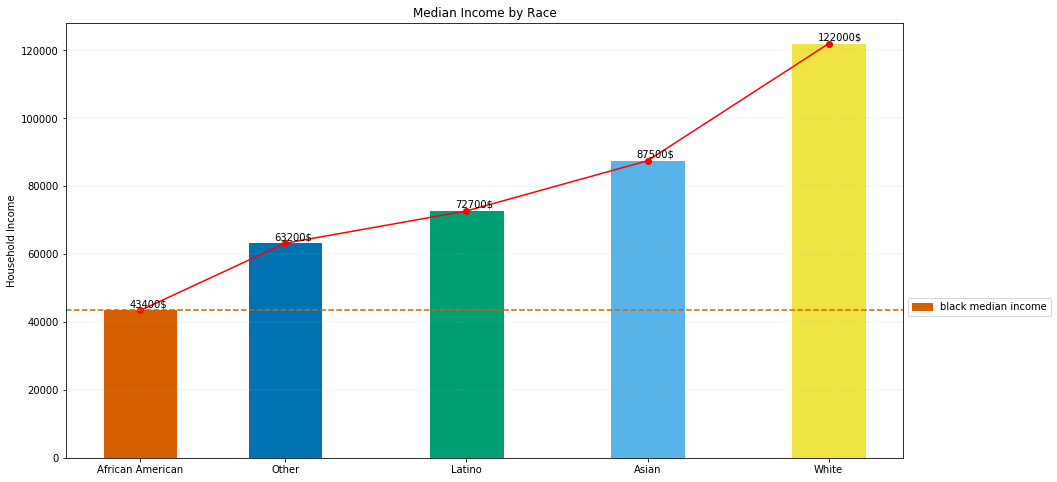

In [18]:
df_incgroup1 = df_incgroup.reindex([0, 3, 2, 1, 4]).reset_index().drop(columns=['index'])
df_incgroup1["HINCP"] = df_incgroup1["HINCP"].round(0).astype(np.int64)
x = df_incgroup1["RACE"]
y = df_incgroup1["HINCP"]

fig = plt.figure(figsize = (15,8))
y_pos = [0.1,0.5,1,1.5,2]
inc_bar = plt.bar(y_pos, y, color = "darkblue", width = 0.2)
i = 1.0
j = 1000
for i in range(len(x)):
    plt.annotate(str(y[i]) + "$", (-0.03 + y_pos[i], y[i] + j))
    
plt.xticks(y_pos, x)
inc_bar[0].set_color('#D55E00')
inc_bar[1].set_color('#0072B2')
inc_bar[2].set_color('#009E73')
inc_bar[3].set_color('#56B4E9')
inc_bar[4].set_color('#F0E442')
inc_line = plt.plot(y_pos, list(y), marker = 'o', color = "red")
plt.grid(axis = "y", linestyle = "-.", linewidth = 0.2)
plt.axhline(y = 43400, color = '#D55E00', linestyle = '--')
line_legend = mpatches.Patch(color = '#D55E00', label = 'black median income')
plt.legend(handles = [line_legend], bbox_to_anchor = (1.0, 0.38), loc = 'upper left')
plt.title("Median Income by Race")
plt.ylabel("Household Income")
plt.show()

In [19]:
df_inc2 = indi8[2]
df_inc_black = df_inc2[(df_inc2.RACE == 'African American')].HINCP.tolist()
df_inc_white = df_inc2[(df_inc2.RACE == 'White')].HINCP.tolist()
df_inc_asian = df_inc2[(df_inc2.RACE == 'Asian')].HINCP.tolist()
df_inc_latino = df_inc2[(df_inc2.RACE == 'Latino')].HINCP.tolist()
df_inc_other = df_inc2[(df_inc2.RACE == 'Other')].HINCP.tolist()
df_inc_byrace = pd.DataFrame(list(zip(df_inc_black, df_inc_asian, df_inc_white, df_inc_latino, df_inc_other)), columns = ["African American", "Asian", "White", "Latino", "Other"])

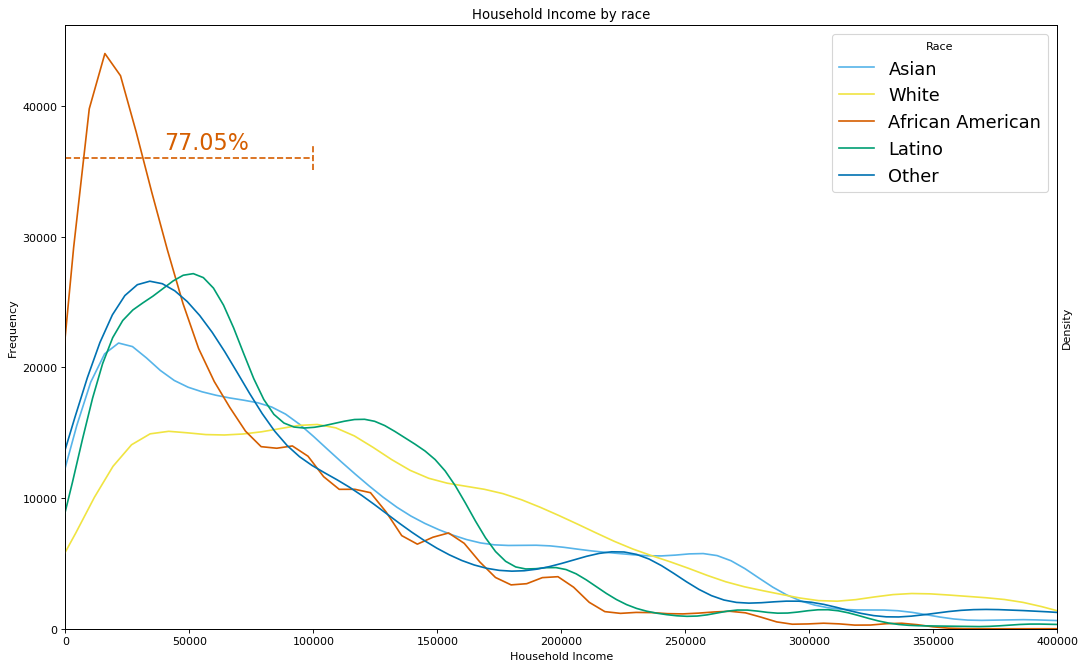

In [20]:
df_inc2_race = list(df_inc2.RACE.unique())
plt.figure(figsize=(16,10), dpi= 80)
ax = sns.distplot(df_inc2.HINCP, kde = False, color = "white")
second_ax = ax.twinx()
c_list = ["#56B4E9", "#F0E442", "#D55E00", "#009E73", "#0072B2"]

for race, color in zip(df_inc2_race,c_list):
    subset = df_inc2[df_inc2['RACE'] == race]
    
    line = sns.distplot(subset['HINCP'], hist = False, kde = True, label = race, ax = second_ax, color = color)
    
   
plt.xlim(0,400000)  
plt.title('Household Income by race')
ax.set(xlabel = "Household Income", ylabel = "Frequency")
second_ax.set_yticks([])
plt.axhline(y = 0.00001, xmax = 0.25, color = '#D55E00', linestyle = '--')
plt.axvline(x = 100000, ymax = 0.8, ymin = 0.76, color = '#D55E00', linestyle = '--')
plt.text(40000, 0.0000102, '77.05%', fontsize=20, color='#D55E00')
plt.legend(prop={'size': 16}, title = 'Race')

In [21]:
df_inc2_black = df_inc2[(df_inc2.RACE == 'African American')]
df_inc2_black_10k = df_inc2_black[(df_inc2_black.HINCP <= 100000)]

In [22]:
len(df_inc2_black_10k) / len(df_inc2_black)

0.7705491359034666

we can see that after 20,000 dollars the frequency of black's household income is clearly lesser than other races when the household income increases. The highest frequency for black's household income in 2019 was about 20,000 dollars.

In [23]:
recolumns = ["African American", "Other", "Latino", "Asian", "White"]
df_inc_byrace = df_inc_byrace.reindex(columns = recolumns)

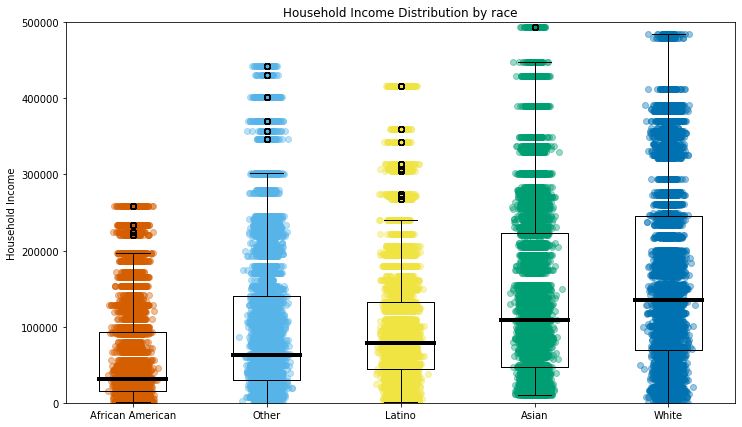

In [24]:
vals, names, xs = [],[],[]

for i, col in enumerate(df_inc_byrace.columns):
    #append each column's value
    vals.append(df_inc_byrace[col].values)
    #append each column's name
    names.append(col)
    #append random Gaussian distribution for the plot (to see the density of data in boxplot)
    xs.append(np.random.normal(i + 1, 0.05, df_inc_byrace[col].values.shape[0]))
    
fig = plt.figure(figsize = (12,7))
#plot a normal boxplot.
bp = plt.boxplot(vals, labels = names, showfliers = True)
for median in bp['medians']:
    median.set(color ='black',
               linewidth = 4)
palette = ['#D55E00', '#56B4E9', '#F0E442', '#009E73', '#0072B2']
#plot scatter plot into boxplot for more visualization.
for  x, val, c in zip(xs, vals, palette):
    plt.scatter(x, val, alpha = 0.4, color = c)
    
plt.ylim(0,500000) 
plt.ylabel("Household Income")
plt.title("Household Income Distribution by race")
plt.show()

the box is where most of them are at(trends).
 
black line is median.
 
dot is outliners. an observation that lies outside the overall pattern of a distribution.

the interquartile range (25 to 75 percentile) and median of black's household income are lower than other two.

mannwhitneyu

In [25]:
stat, p = mannwhitneyu(df_inc_black, df_inc_white)
print(f'Statistics = {stat}, p-value = {p}')
alpha = 0.05
if p > alpha:
    print('Fail to reject H0: Same distribution')
else:
    print('Reject H0: Different distribution')

Statistics = 1098979562.0, p-value = 0.0
Reject H0: Different distribution


Ranksums

In [26]:
ranksums(df_inc_black, df_inc_white)

RanksumsResult(statistic=-153.80640242414879, pvalue=0.0)

T test

In [27]:
t2, p2 = stats.ttest_ind(df_inc_black,df_inc_white)
print("t = " + str(t2))
print("p = " + str(p2))

t = -122.85662012176073
p = 0.0


All three statistical tests show that There is significant different between median household income of black and white.

## Poverty<a id='ind9'> 

## Ind9 function

In [28]:
def ind9_2019(df):
    pov = ["RACE", "POVPIP"]
    df_pov = df[pov]
    df_pov1 = df_pov[(df_pov.RACE == 'White') | (df_pov.RACE == 'African American') | (df_pov.RACE == 'Asian') | (df_pov.RACE == 'Latino') | (df_pov.RACE == 'Other')]
    df_pov2 = df_pov1.dropna(subset=['POVPIP'])

    pov_cat = []
    pov_list = df_pov2["POVPIP"].tolist()

    # if equal or below 100, census recorded it as poverty. According to census's SPSS script.
    for i in pov_list:
        if i <= 100:
            pov_cat.append(1)
        else:
            pov_cat.append(0)
    df_pov2["POV"] = pov_cat

    pov_table = pd.crosstab(df_pov2["RACE"], df_pov2["POV"])
    pov_percent = []
    for i in pov_table.index.tolist():
        pov_table.loc[i, "pov_percent"] = pov_table.loc[i,1] / (pov_table.loc[i,0] + pov_table.loc[i,1])*100
        
    pov_table["pov_percent"] = pov_table["pov_percent"].round(2)
    pov_table = pov_table.reset_index()
    pov_total_0 = pov_table[[0]].sum().iloc[0]
    pov_total_1 = pov_table[[1]].sum().iloc[0]
    pov_total_percent = pov_table[[1]].sum().iloc[0]/pov_table[[0]].sum().iloc[0] * 100
    new_pov = {"RACE": "Total", 0: [pov_total_0], 1: [pov_total_1], "pov_percent": [pov_total_percent]}
    new_pov_df = pd.DataFrame(new_pov)
    pov_table = pd.concat([pov_table, new_pov_df], ignore_index = True)
    pov_table["pov_percent"] = pov_table["pov_percent"].round(3)
    pov_table.columns = ["RACE", "not_pov", "pov", "pov_percent"]
    df_pov = pov_table
    pov_black = pov_table.loc[pov_table["RACE"] == 'African American', "pov_percent"].iloc[0]
    pov_white = pov_table.loc[pov_table["RACE"] == 'White', "pov_percent"].iloc[0]
    pov_ratio = pov_black / pov_white
    Ind9_result = print(f'Pov Ratio = {round(pov_ratio, 2)}')
    return df_pov, Ind9_result, df_pov2

In [29]:
indi9 = ind9_2019(pca191_Ok)
pov_table = indi9[0]

Pov Ratio = 4.33


## Ratio/Score Black-to-White poverty rate

In [30]:
pov_black = pov_table.loc[pov_table["RACE"] == 'African American', "pov_percent"].iloc[0]
pov_white = pov_table.loc[pov_table["RACE"] == 'White', "pov_percent"].iloc[0]
pov_asian = pov_table.loc[pov_table["RACE"] == 'Asian', "pov_percent"].iloc[0]
pov_latino = pov_table.loc[pov_table["RACE"] == 'Latino', "pov_percent"].iloc[0]
pov_ratio = pov_black / pov_white
print(f'white poverty rate = {pov_white}%')
print(f'black poverty rate = {pov_black}%')
print(f'asian poverty rate = {pov_asian}%')
print(f'latino poverty rate = {pov_latino}%')
print(f'Pov Ratio = {round(pov_ratio, 2)}')
print("Poverty score = 25")

white poverty rate = 5.62%
black poverty rate = 24.36%
asian poverty rate = 9.69%
latino poverty rate = 17.55%
Pov Ratio = 4.33
Poverty score = 25


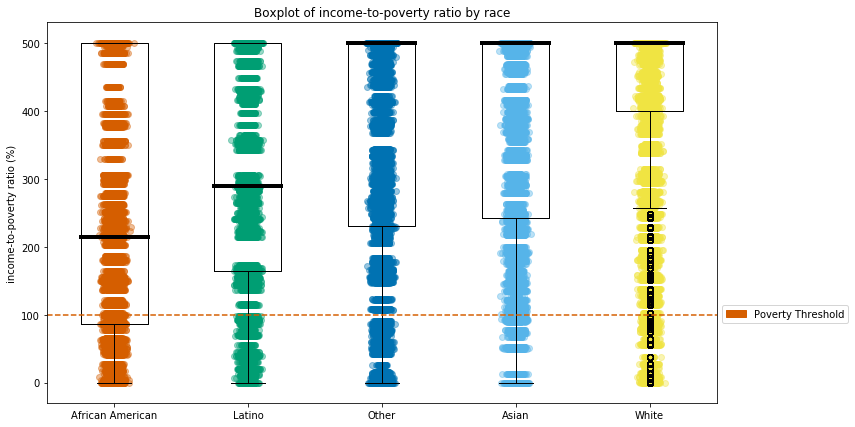

In [31]:
df_pov2 = indi9[2]
df_pov_black = df_pov2[(df_pov2.RACE == 'African American')].POVPIP.tolist()
df_pov_white = df_pov2[(df_pov2.RACE == 'White')].POVPIP.tolist()
df_pov_asian = df_pov2[(df_pov2.RACE == 'Asian')].POVPIP.tolist()
df_pov_latino = df_pov2[(df_pov2.RACE == 'Latino')].POVPIP.tolist()
df_pov_other = df_pov2[(df_pov2.RACE == 'Other')].POVPIP.tolist()
df_pov_byrace = pd.DataFrame(list(zip(df_pov_black, df_pov_latino, df_pov_other, df_pov_asian, df_pov_white)), columns = ["African American", "Latino", "Other", "Asian", "White"])

vals, names, xs = [],[],[]

for i, col in enumerate(df_pov_byrace.columns):
    #append each column's value
    vals.append(df_pov_byrace[col].values)
    #append each column's name
    names.append(col)
    #append radom Gaussian distribution for the plot (to see the density of data in boxplot)
    xs.append(np.random.normal(i + 1, 0.03, df_pov_byrace[col].values.shape[0]))
    
fig = plt.figure(figsize = (12,7))
#plot a normal boxplot.
bp = plt.boxplot(vals, labels = names)
for median in bp['medians']:
    median.set(color ='black',
               linewidth = 4)

palette = ['#D55E00', '#009E73', '#0072B2', '#56B4E9', '#F0E442']
#plot scatter plot into boxplot for more visualization.
for  x, val, c in zip(xs, vals, palette):
    plt.scatter(x, val, alpha = 0.4, color = c)
    
plt.axhline(y = 100, color = '#D55E00', linestyle= '--')
line_legend = mpatches.Patch(color = '#D55E00', label = 'Poverty Threshold')
plt.legend(handles = [line_legend], bbox_to_anchor=(1.0, 0.27), loc = 'upper left')
plt.title("Boxplot of income-to-poverty ratio by race")
plt.ylabel("income-to-poverty ratio (%)")
plt.show()

both asian and white income-to-poverty medians are significantly higher than black. Also, data of black income-to-poverty ratio that below "Poverty Threshold" is much denser than other two races.

In [32]:
stat, p = mannwhitneyu(df_pov_black, df_pov_white)
print(f'Statistics = {stat}, p-value = {p}')
alpha = 0.05
if p > alpha:
    print('Fail to reject H0: Same distribution')
else:
    print('Reject H0: Different distribution')

t2, p2 = stats.ttest_ind(df_inc_black,df_inc_white)
print(" ")
print("T-test")
print("t = " + str(t2))
print("p = " + str(p2))

ranksums(df_pov_black, df_pov_white)

Statistics = 6270172284.0, p-value = 0.0
Reject H0: Different distribution
 
T-test
t = -122.85662012176073
p = 0.0


RanksumsResult(statistic=-213.44738388939268, pvalue=0.0)

All statistical tests have significantly small p-value. Mean that there is a statistically significant difference.

In [33]:
ind2019_6_8_9 = indi6[0].set_index('RACE')
ind2019_6_8_9['HINCP'] = indi8[0].HINCP.values
ind2019_6_8_9['pov_percent'] = indi9[0].pov_percent.values
ind2019_6_8_9.columns = ["Ind6", "Ind8", "Ind9"]
ind2019_6_8_9

,Ind6,Ind8,Ind9
RACE,,,
African American,8.17,43400.0,24.360
Asian,3.53,87500.0,9.690
Latino,4.19,72700.0,17.550
Other,4.70,63200.0,10.390
White,3.27,122000.0,5.620
Total,23.86,88600.0,15.338


In [34]:
df_x1 = pca191_Ok[pca191_Ok.HINCP >1]
df_x1 = df_x1[df_x1.RELSHIPP == 20]
x1 = ["RACE", "HINCP", "POVPIP"]
df_x1 = df_x1[x1]
df_x1 = df_x1[(df_x1.RACE == "White") | (df_x1.RACE == "African American")]
df_x1 = df_x1.dropna(subset=["HINCP"])

In [35]:
df_x1.head()

,RACE,HINCP,POVPIP
6927,White,237000.0,501.0
6928,White,237000.0,501.0
6929,White,237000.0,501.0
6930,White,237000.0,501.0
6931,White,237000.0,501.0


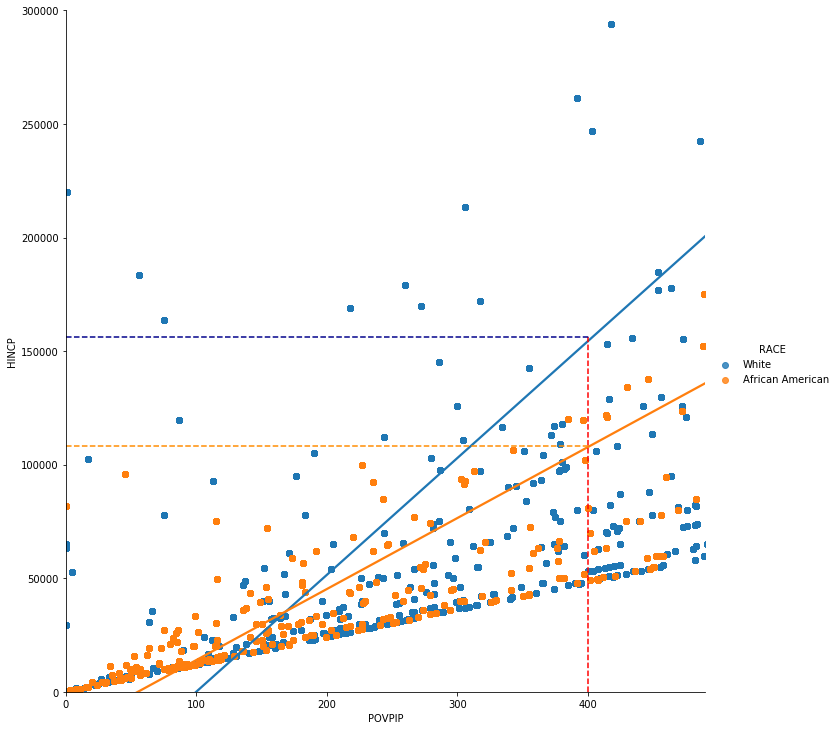

In [36]:
sns.lmplot(x="POVPIP",
           y="HINCP",
           hue="RACE",
           ci=None,
           data=df_x1,
           height=10)
plt.ylim([0,300000])
plt.xlim([0,490])
plt.axvline(x = 400, ymax = 0.52, color = "red", linestyle = "--")
plt.axhline(y = 156000, xmax = 0.82, color = "darkblue", linestyle = "--")
plt.axhline(y = 108000, xmax = 0.82, color = "darkorange", linestyle = "--")
plt.show()

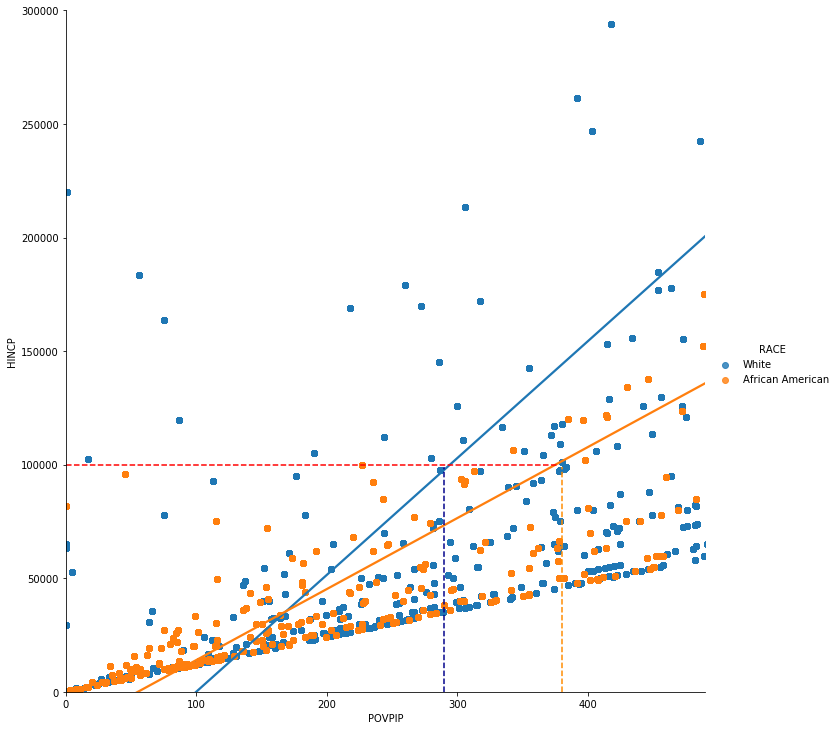

In [37]:
sns.lmplot(x="POVPIP",
           y="HINCP",
           hue="RACE",
           ci=None,
           data=df_x1,
           height=10)
plt.ylim([0,300000])
plt.xlim([0,490])
plt.axvline(x = 380, ymax = 0.33, color = "darkorange", linestyle = "--")
plt.axvline(x = 290, ymax = 0.33, color = "darkblue", linestyle = "--")
plt.axhline(y = 100000, xmax = 0.77, color = "red", linestyle = "--")
plt.show()

## Ind3 Long Term Business Vacancy<a id='ind3'> 

In [61]:
def ind3_2019(df_census, df_hud):
    df_census = df_census
    df_hud = df_hud
    # cleaning df_census
    df_census.columns = df_census.iloc[0]
    df_census = df_census.drop(0).reset_index(drop=True)
    df_census['id'] = df_census['id'].str.replace('1400000US', '')
    df_census = df_census[["id", "Estimate!!Total:", "Estimate!!Total:!!Not Hispanic or Latino:!!White alone",
                           "Estimate!!Total:!!Not Hispanic or Latino:!!Black or African American alone",
                           "Estimate!!Total:!!Not Hispanic or Latino:!!Asian alone", "Estimate!!Total:!!Hispanic or Latino:"]]
    df_census.columns = ["id", "Total", "White", "Black", "Asian", "Latino"]
    selected = ["06001400100","06001400200","06001400300","06001400400","06001400500","06001400600","06001400700","06001400800",
                "06001400900","06001401000","06001401100","06001401200","06001401300","06001401400","06001401500","06001401600",
                "06001401700","06001401800","06001402200","06001402400","06001402500","06001402600","06001402700","06001402800",
                "06001402900","06001403000","06001403100","06001403300","06001403400","06001403501","06001403502","06001403600",
                "06001403701","06001403702","06001403800","06001403900","06001404000","06001404101","06001404102","06001404200",
                "06001404300","06001404400","06001404501","06001404502","06001404600","06001404700","06001404800","06001404900",
                "06001405000","06001405100","06001405200","06001405301","06001405302","06001405401","06001405402","06001405500",
                "06001405600","06001405700","06001405800","06001405901","06001405902","06001406000","06001406100","06001406201",
                "06001406202","06001406300","06001406400","06001406500","06001406601","06001406602","06001406700","06001406800",
                "06001406900","06001407000","06001407101","06001407102","06001407200","06001407300","06001407400","06001407500",
                "06001407600","06001407700","06001407800","06001407900","06001408000","06001408100","06001408200","06001408300",
                "06001408400","06001408500","06001408600","06001408700","06001408800","06001408900","06001409000","06001409100",
                "06001409200","06001409300","06001409400","06001409500","06001409600","06001409700","06001409800","06001409900",
                "06001410000","06001410100","06001410200","06001410300","06001410400","06001410500","06001981900","06001982000","06001983200"]
    df_census = df_census[df_census['id'].isin(selected)]
    df_census['Total'] = pd.to_numeric(df_census['Total'])
    df_census['White'] = pd.to_numeric(df_census['White'])
    df_census['Black'] = pd.to_numeric(df_census['Black'])
    df_census['Asian'] = pd.to_numeric(df_census['Asian'])
    df_census['Latino'] = pd.to_numeric(df_census['Latino'])
    df_census["majority"] = df_census.drop(columns=["id","Total"]).idxmax(axis=1)
    df_census = df_census.reset_index(drop = True)
    major_race = []
    
    for i in range(len(df_census)):
        max_race = df_census.loc[i,"majority"]
        max_val = df_census.loc[i,max_race]
        total = df_census.loc[i,"Total"]
        if max_val > (total*0.5):
            major_race.append(max_race)
        else:
            major_race.append("Other")
            
    df_census["Majority"] = major_race
    df_census_final = df_census[["id", "Majority"]]
    #cleaning df_hud
    df_hud = df_hud[["geoid", "vac_24_36b", "vac_36_bus", "ams_bus"]]
    df_hud = df_hud[df_hud['geoid'].isin(selected)]
    df_hud = df_hud.rename(columns = {"geoid": "id"})
    #merge data
    df_merge = df_hud.merge(df_census_final, how = "inner", on = "id")
    df_merge = df_merge.drop(columns="id").reset_index(drop = True)
    df_merge["vac"] = df_merge.vac_24_36b + df_merge.vac_36_bus
    df_merge = df_merge.drop(columns=["vac_24_36b","vac_36_bus"])
    df_merge = df_merge.groupby(["Majority"]).sum().reset_index()
    sum_ams = df_merge.ams_bus.sum()
    sum_vac = df_merge.vac.sum()
    total_row = ['Total', sum_ams, sum_vac]
    df_merge.loc[len(df_merge)] = total_row
    df_merge["vac%"] = round(df_merge.vac / df_merge.ams_bus * 100,2)
    df_merge = df_merge.drop(columns=["ams_bus","vac"])
    df_merge.columns = ['RACE', 'ind3']
    
    return df_merge

In [62]:
hud2019q3 = pd.DataFrame(iter(DBF('HUD2019Q3.dbf', encoding = 'GBK')))
census2019CA = pd.read_csv("census2019CA.csv")

In [63]:
ind3_result_2019 = ind3_2019(census2019CA, hud2019q3)
ind3_result_2019

,RACE,ind3
0,Asian,7.74
1,Black,2.09
2,Latino,3.01
3,Other,2.87
4,White,1.50
5,Total,3.03


## Ind63 Long Term Residential Vacancy

In [64]:
def ind63_2019(df_census, df_hud):
    df_census = df_census
    df_hud = df_hud
    # cleaning df_census
    df_census.columns = df_census.iloc[0]
    df_census = df_census.drop(0).reset_index(drop=True)
    df_census['id'] = df_census['id'].str.replace('1400000US', '')
    df_census = df_census[["id", "Estimate!!Total:", "Estimate!!Total:!!Not Hispanic or Latino:!!White alone",
                           "Estimate!!Total:!!Not Hispanic or Latino:!!Black or African American alone",
                           "Estimate!!Total:!!Not Hispanic or Latino:!!Asian alone", "Estimate!!Total:!!Hispanic or Latino:"]]
    df_census.columns = ["id", "Total", "White", "Black", "Asian", "Latino"]
    selected = ["06001400100","06001400200","06001400300","06001400400","06001400500","06001400600","06001400700","06001400800",
                "06001400900","06001401000","06001401100","06001401200","06001401300","06001401400","06001401500","06001401600",
                "06001401700","06001401800","06001402200","06001402400","06001402500","06001402600","06001402700","06001402800",
                "06001402900","06001403000","06001403100","06001403300","06001403400","06001403501","06001403502","06001403600",
                "06001403701","06001403702","06001403800","06001403900","06001404000","06001404101","06001404102","06001404200",
                "06001404300","06001404400","06001404501","06001404502","06001404600","06001404700","06001404800","06001404900",
                "06001405000","06001405100","06001405200","06001405301","06001405302","06001405401","06001405402","06001405500",
                "06001405600","06001405700","06001405800","06001405901","06001405902","06001406000","06001406100","06001406201",
                "06001406202","06001406300","06001406400","06001406500","06001406601","06001406602","06001406700","06001406800",
                "06001406900","06001407000","06001407101","06001407102","06001407200","06001407300","06001407400","06001407500",
                "06001407600","06001407700","06001407800","06001407900","06001408000","06001408100","06001408200","06001408300",
                "06001408400","06001408500","06001408600","06001408700","06001408800","06001408900","06001409000","06001409100",
                "06001409200","06001409300","06001409400","06001409500","06001409600","06001409700","06001409800","06001409900",
                "06001410000","06001410100","06001410200","06001410300","06001410400","06001410500","06001981900","06001982000","06001983200"]
    df_census = df_census[df_census['id'].isin(selected)]
    df_census['Total'] = pd.to_numeric(df_census['Total'])
    df_census['White'] = pd.to_numeric(df_census['White'])
    df_census['Black'] = pd.to_numeric(df_census['Black'])
    df_census['Asian'] = pd.to_numeric(df_census['Asian'])
    df_census['Latino'] = pd.to_numeric(df_census['Latino'])
    df_census["majority"] = df_census.drop(columns=["id","Total"]).idxmax(axis=1)
    df_census = df_census.reset_index(drop = True)
    major_race = []
    
    for i in range(len(df_census)):
        max_race = df_census.loc[i,"majority"]
        max_val = df_census.loc[i,max_race]
        total = df_census.loc[i,"Total"]
        if max_val > (total*0.5):
            major_race.append(max_race)
        else:
            major_race.append("Other")
            
    df_census["Majority"] = major_race
    df_census_final = df_census[["id", "Majority"]]
    #cleaning df_hud
    df_hud = df_hud[["geoid", "vac_24_36r", "vac_36_res", "ams_res"]]
    df_hud = df_hud[df_hud['geoid'].isin(selected)]
    df_hud = df_hud.rename(columns = {"geoid": "id"})
    #merge data
    df_merge = df_hud.merge(df_census_final, how = "inner", on = "id")
    df_merge = df_merge.drop(columns="id").reset_index(drop = True)
    df_merge["res"] = df_merge.vac_24_36r + df_merge.vac_36_res
    df_merge = df_merge.drop(columns=["vac_24_36r","vac_36_res"])
    df_merge = df_merge.groupby(["Majority"]).sum().reset_index()
    sum_ams = df_merge.ams_res.sum()
    sum_res = df_merge.res.sum()
    total_row = ['Total', sum_ams, sum_res]
    df_merge.loc[len(df_merge)] = total_row
    df_merge["res%"] = round(df_merge.res / df_merge.ams_res * 100,2)
    df_merge = df_merge.drop(columns=["ams_res","res"])
    df_merge.columns = ['RACE', 'ind63']
    
    return df_merge

In [65]:
ind63_result_2019 = ind63_2019(census2019CA, hud2019q3)
ind63_result_2019

,RACE,ind63
0,Asian,1.16
1,Black,0.57
2,Latino,0.42
3,Other,0.50
4,White,0.45
5,Total,0.49


## 2018

In [38]:
pca181 = pd.read_csv("2018pCA1.csv")
hca181 = pd.read_csv("2018hCA1.csv")
pca181_Ok = cleanData(pca181, hca181, False)

In [39]:
print("Dimensions for the final person dataset: " + str(pca181_Ok.shape))
print("New DataFrame size: " + str(int(pca181_Ok.memory_usage(index=True).sum()/1000000)) + " MB")

Dimensions for the final person dataset: (622007, 65)
New DataFrame size: 323 MB


In [40]:
def ind6_2018(df):
    va_unem = ["RACE", "AGEP", "SEX", "COW", "FER", "MAR", "PAOC", "MIL", "ESR", "RETP"]
    df_unem = df[va_unem]
    # less than 16 is not counted as labor force.
    df_unem1 = df_unem[df_unem.AGEP >= 16]
    # category 6 means not in labor force.
    df_unem2 = df_unem1[df_unem1.ESR != 6]
    df_unem2.dropna(subset=['ESR'])
    # in ESR variables, there are 6 category. number 3 only means unemployment so, change others to one value.
    change_unem = {1:1, 2:1, 3:0, 4:1, 5:1}
    df_unem2["ESR"] = df_unem2["ESR"].map(change_unem)
    # select only white, black, and asian because others data is not enough.
    df_unem3 = df_unem2[(df_unem2.RACE == 'White') | (df_unem2.RACE == 'African American') | (df_unem2.RACE == 'Asian') | (df_unem2.RACE == 'Latino') | (df_unem2.RACE == 'Other')]
    df_unem3.dropna(subset=['RACE'])
    df_unemgroup = df_unem3.groupby(["RACE"])["ESR"].mean()
    df_unemgroup = df_unemgroup.to_frame()
    df_unemgroup['UnemploymentRate%']  = (1 - df_unemgroup.ESR)*100
    df_unemgroup = df_unemgroup.drop(columns=['ESR'])
    df_unemgroup_total = df_unemgroup["UnemploymentRate%"].sum()
    df_unemgroup.loc[len(df_unemgroup)] = [df_unemgroup_total]
    df_unemgroup = df_unemgroup.reset_index()
    df_unemgroup.loc[len(df_unemgroup)-1, "RACE"] = "Total"
    df_unemgroup["UnemploymentRate%"] = df_unemgroup["UnemploymentRate%"].round(3)
    return df_unemgroup

def ind8_2018(df):
    df_merge1 = df[df.HINCP > 1]
    df_merge2 = df_merge1[df_merge1.RELP  == 0]
    inc = ["RACE", "HINCP"]
    df_inc = df_merge2[inc]
    # select only white, black, and asian.
    df_inc1 = df_inc[(df_inc.RACE == 'White') | (df_inc.RACE == 'African American') | (df_inc.RACE == 'Asian') | (df_inc.RACE == 'Latino') | (df_inc.RACE == 'Other')]
    df_inc2 = df_inc1.dropna(subset=['HINCP'])
    # find the median of each race.
    df_incgroup = df_inc2.groupby(["RACE"])["HINCP"].median().to_frame()
    df_incgroup_total = df_inc2.HINCP.median()
    df_incgroup.loc[len(df_incgroup)] = [df_incgroup_total]
    df_incgroup = df_incgroup.reset_index()
    df_incgroup.loc[len(df_incgroup) - 1, "RACE"] = "Total"
    return df_incgroup
    
def ind9_2018(df):
    pov = ["RACE", "POVPIP"]
    df_pov = df[pov]
    df_pov1 = df_pov[(df_pov.RACE == 'White') | (df_pov.RACE == 'African American') | (df_pov.RACE == 'Asian') | (df_pov.RACE == 'Latino') | (df_pov.RACE == 'Other')]
    df_pov2 = df_pov1.dropna(subset=['POVPIP'])

    pov_cat = []
    pov_list = df_pov2["POVPIP"].tolist()

    # if equal or below 100, census recorded it as poverty. According to census's SPSS script.
    for i in pov_list:
        if i <= 100:
            pov_cat.append(1)
        else:
            pov_cat.append(0)
    df_pov2["POV"] = pov_cat

    pov_table = pd.crosstab(df_pov2["RACE"], df_pov2["POV"])
    pov_percent = []
    for i in pov_table.index.tolist():
        pov_table.loc[i, "pov_percent"] = pov_table.loc[i,1] / (pov_table.loc[i,0] + pov_table.loc[i,1])*100
        
    pov_table["pov_percent"] = pov_table["pov_percent"].round(2)
    pov_table = pov_table.reset_index()
    pov_total_0 = pov_table[[0]].sum().iloc[0]
    pov_total_1 = pov_table[[1]].sum().iloc[0]
    pov_total_percent = pov_table[[1]].sum().iloc[0]/pov_table[[0]].sum().iloc[0] * 100
    new_pov = {"RACE": "Total", 0: [pov_total_0], 1: [pov_total_1], "pov_percent": [pov_total_percent]}
    new_pov_df = pd.DataFrame(new_pov)
    pov_table = pd.concat([pov_table, new_pov_df], ignore_index = True)
    pov_table["pov_percent"] = pov_table["pov_percent"].round(3)
    pov_table.columns = ["RACE", "not_pov", "pov", "pov_percent"]
    df_pov = pov_table
    return df_pov

In [41]:
df_unemgroup = ind6_2018(pca181_Ok)
df_incgroup = ind8_2018(pca181_Ok)
df_pov = ind9_2018(pca181_Ok)

In [42]:
ind2018_6_8_9 = df_unemgroup.set_index('RACE')
ind2018_6_8_9['HINCP'] = df_incgroup.HINCP.values
ind2018_6_8_9['pov_percent'] = df_pov.pov_percent.values
ind2018_6_8_9.columns = ["Ind6", "Ind8", "Ind9"]
ind2018_6_8_9

,Ind6,Ind8,Ind9
RACE,,,
African American,7.987,50000.0,18.170
Asian,3.977,77700.0,11.250
Latino,5.195,67800.0,13.290
Other,6.306,107000.0,6.860
White,3.135,116000.0,6.740
Total,26.600,82000.0,12.793


## Machine learning <a id='lr'> 

### Linear Regression

Predicting Total personal earning.

In [43]:
pom = ["PERNP", "RACE", "SEX", "ENG", "HICOV", "CIT", "ESR", "SCIENGP", "AGEP", "WKHP"]
df_pom = pca191_Ok[pom]

#### Data Cleaning

In [44]:
df_pom = df_pom[(df_pom.ESR != 6) | (df_pom.ESR != 3) | (df_pom.PERNP > 0)]
df_pom.SCIENGP = df_pom.SCIENGP.fillna(0)
change_r = {'White': 0, 'African American': 1, 'Asian':2, 'Latino':3, 'Other':4}
df_pom.RACE = df_pom.RACE.map(change_r)
change_e = {1:0, 2:0, 4:1, 5:1}
df_pom.ESR = df_pom.ESR.map(change_e)
df_pom = df_pom.dropna()

In [45]:
df_pom.head()

,PERNP,RACE,SEX,ENG,HICOV,CIT,ESR,SCIENGP,AGEP,WKHP
13,17000.0,2,1,2.0,1,4,0.0,2.0,34,8.0
14,17000.0,2,1,2.0,1,4,0.0,2.0,34,8.0
15,17000.0,2,1,2.0,1,4,0.0,2.0,34,8.0
16,17000.0,2,1,2.0,1,4,0.0,2.0,34,8.0
568,20000.0,2,2,1.0,1,4,0.0,2.0,34,40.0


In [46]:
for col in ['RACE', 'SEX', 'ENG', 'HICOV', 'CIT', 'ESR', 'SCIENGP']:
    df_pom[col] = df_pom[col].astype('category')

#### Dummies

In [47]:
df_dum = df_pom[["RACE", "ENG", "CIT", "SCIENGP"]]
df_dum = pd.get_dummies(df_dum)
df_nu = df_pom[["PERNP", "SEX", "HICOV", "ESR", "AGEP","WKHP"]]
df = pd.concat([df_nu, df_dum], axis = 1, join = "inner")
df.head()

,PERNP,SEX,HICOV,ESR,AGEP,WKHP,RACE_0,RACE_1,RACE_2,RACE_3,...,ENG_3.0,ENG_4.0,CIT_1,CIT_2,CIT_3,CIT_4,CIT_5,SCIENGP_0.0,SCIENGP_1.0,SCIENGP_2.0
13,17000.0,1,1,0.0,34,8.0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
14,17000.0,1,1,0.0,34,8.0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
15,17000.0,1,1,0.0,34,8.0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
16,17000.0,1,1,0.0,34,8.0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
568,20000.0,2,1,0.0,34,40.0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1


#### split / scaling

In [48]:
# split 70-30
df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100)

#rescale
scaler = MinMaxScaler()
nu_var = ["AGEP", "WKHP"]
df_train[nu_var] = scaler.fit_transform(df_train[nu_var])
df_train.head()

,PERNP,SEX,HICOV,ESR,AGEP,WKHP,RACE_0,RACE_1,RACE_2,RACE_3,...,ENG_3.0,ENG_4.0,CIT_1,CIT_2,CIT_3,CIT_4,CIT_5,SCIENGP_0.0,SCIENGP_1.0,SCIENGP_2.0
183378,104000.0,1,1,0.0,0.230769,0.397959,0,0,1,0,...,1,0,0,0,0,1,0,0,1,0
151680,60000.0,1,1,0.0,0.320513,0.500000,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
434068,130000.0,1,1,0.0,0.179487,0.602041,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
414030,18000.0,2,1,0.0,0.064103,0.234694,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
510759,80000.0,1,2,0.0,0.346154,0.132653,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [49]:
#rescale testset
df_test[nu_var] = scaler.fit_transform(df_test[nu_var])
df_test.head()

,PERNP,SEX,HICOV,ESR,AGEP,WKHP,RACE_0,RACE_1,RACE_2,RACE_3,...,ENG_3.0,ENG_4.0,CIT_1,CIT_2,CIT_3,CIT_4,CIT_5,SCIENGP_0.0,SCIENGP_1.0,SCIENGP_2.0
557727,36000.0,1,1,0.0,0.230769,0.500000,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0
236572,65000.0,1,1,0.0,0.217949,0.377551,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
367928,65000.0,1,1,0.0,0.423077,0.397959,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
198553,125000.0,2,1,0.0,0.269231,0.397959,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
260193,40600.0,1,1,0.0,0.474359,0.500000,0,0,1,0,...,1,0,0,0,0,1,0,1,0,0


In [50]:
y_train = df_train.pop('PERNP')
X_train = df_train
y_test = df_test.pop('PERNP')
X_test = df_test

In [51]:
len(X_train.columns)

22

#### RFE

In [52]:
# pick n_features = 20, just to test
lm = LinearRegression()
lm.fit(X_train, y_train)

model = RFE(lm, n_features_to_select = 20)
model = model.fit(X_train, y_train)

In [53]:
list(zip(X_train.columns,model.support_,model.ranking_))

[('SEX', False, 2),
 ('HICOV', False, 3),
 ('ESR', True, 1),
 ('AGEP', True, 1),
 ('WKHP', True, 1),
 ('RACE_0', True, 1),
 ('RACE_1', True, 1),
 ('RACE_2', True, 1),
 ('RACE_3', True, 1),
 ('RACE_4', True, 1),
 ('ENG_1.0', True, 1),
 ('ENG_2.0', True, 1),
 ('ENG_3.0', True, 1),
 ('ENG_4.0', True, 1),
 ('CIT_1', True, 1),
 ('CIT_2', True, 1),
 ('CIT_3', True, 1),
 ('CIT_4', True, 1),
 ('CIT_5', True, 1),
 ('SCIENGP_0.0', True, 1),
 ('SCIENGP_1.0', True, 1),
 ('SCIENGP_2.0', True, 1)]

In [54]:
# predict
y_pred = model.predict(X_test)

# R2
r2 = metrics.r2_score(y_test, y_pred)
print(r2)

0.26675505220454887


#### K-flod for feature selection

In [55]:
# k-fold cross validation
# use all variables
lm = LinearRegression()
folds = KFold(n_splits = 10, shuffle = True, random_state = 100)
train_scores = cross_val_score(lm, X_train, y_train, scoring ='r2', cv=folds)
print('R2')
print(train_scores)
train_scores = cross_val_score(lm, X_train, y_train, scoring ='neg_mean_squared_error', cv=folds)
print('neg_root_mean_squared_error')
print(train_scores)

R2
[0.27790357 0.28593499 0.26462693 0.26821224 0.27273358 0.28009693
 0.26939011 0.28827519 0.25444868 0.28235895]
neg_root_mean_squared_error
[-3.17988059e+09 -3.60833835e+09 -3.64805128e+09 -3.86386831e+09
 -3.57474411e+09 -3.49324037e+09 -3.75262975e+09 -3.62687481e+09
 -4.04575925e+09 -3.67994696e+09]


In [56]:
# create a cv scheme
folds = KFold(n_splits = 10, shuffle = True, random_state = 100)

#range of hypermeters
hyper_params = [{'n_features_to_select': list(range(1,23))}]

# grid search
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)

model_cv = GridSearchCV(estimator = rfe, param_grid = hyper_params, scoring= 'r2', cv = folds, verbose = 1, return_train_score=True)
model_cv.fit(X_train, y_train)

Fitting 10 folds for each of 22 candidates, totalling 220 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22]}],
             return_train_score=True, scoring='r2', verbose=1)

In [57]:
cv_result = pd.DataFrame(model_cv.cv_results_)
cv_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.414181,0.032532,0.006583,0.000490,1,{'n_features_to_select': 1},0.080681,0.161665,0.088206,0.083573,...,0.085738,0.086268,0.156148,0.032542,0.156013,0.154905,0.033297,0.032433,0.097908,0.051444
1,0.385383,0.031243,0.006482,0.000499,2,{'n_features_to_select': 2},0.156050,0.163713,0.160531,0.157751,...,0.158925,0.159242,0.159205,0.037183,0.158755,0.158103,0.037870,0.036952,0.122411,0.055697
2,0.403835,0.026426,0.007081,0.000941,3,{'n_features_to_select': 3},0.156049,0.163707,0.160527,0.157737,...,0.158925,0.159241,0.159202,0.037636,0.158753,0.158101,0.038338,0.037469,0.122554,0.055477
3,0.383987,0.018607,0.007081,0.000299,4,{'n_features_to_select': 4},0.161521,0.169272,0.164120,0.159998,...,0.163683,0.161834,0.185873,0.037636,0.163576,0.158211,0.038322,0.037456,0.127357,0.059048
4,0.362743,0.011734,0.007080,0.000299,5,{'n_features_to_select': 5},0.161608,0.169282,0.164132,0.162847,...,0.163710,0.164599,0.191886,0.162804,0.163603,0.159589,0.107839,0.163451,0.160451,0.019566
5,0.352421,0.014735,0.007580,0.000488,6,{'n_features_to_select': 6},0.161706,0.169327,0.164229,0.164580,...,0.163732,0.166584,0.192003,0.165792,0.163623,0.162677,0.168723,0.166508,0.167672,0.008309
6,0.349029,0.011845,0.007679,0.000457,7,{'n_features_to_select': 7},0.161656,0.169360,0.164217,0.164596,...,0.163737,0.166585,0.192010,0.165792,0.163630,0.162717,0.168723,0.166508,0.167679,0.008308
7,0.339104,0.012415,0.007879,0.000299,8,{'n_features_to_select': 8},0.161722,0.169305,0.164221,0.164038,...,0.163740,0.167589,0.192005,0.190878,0.163628,0.162719,0.169572,0.192622,0.172983,0.012512
8,0.374464,0.034565,0.008477,0.000499,9,{'n_features_to_select': 9},0.163038,0.170916,0.167399,0.165906,...,0.168724,0.169524,0.194444,0.199541,0.165084,0.189615,0.171546,0.201324,0.178984,0.014517
9,0.347335,0.022332,0.008577,0.000489,10,{'n_features_to_select': 10},0.164907,0.173227,0.168499,0.179602,...,0.169403,0.186863,0.198223,0.199700,0.167357,0.194709,0.188697,0.201533,0.184110,0.013960


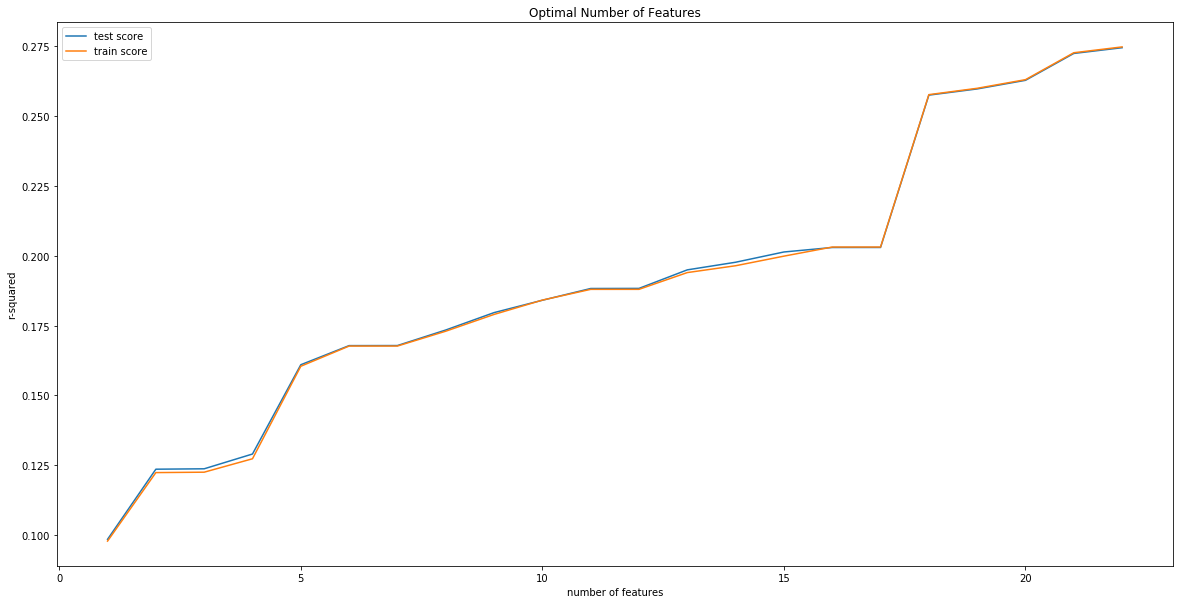

In [58]:
# plotting cv results
plt.figure(figsize=(20,10))

plt.plot(cv_result["param_n_features_to_select"], cv_result["mean_test_score"])
plt.plot(cv_result["param_n_features_to_select"], cv_result["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

#### model with optimal number of feature.

In [59]:
# opt. n_features
opt_n_features = 18

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select = opt_n_features)
rfe = rfe.fit(X_train, y_train)

# predict
y_pred = rfe.predict(X_test)
r2 = metrics.r2_score(y_test, y_pred)
print(r2)

0.2627534352752272


### Logistic Regression<a id='lor'> 

Our team decided to present Lin's decision tree model and Jaime's logistic regression. Jaime was busy creating the web application so I help him improve his model.

In [67]:
pca191 = pd.read_csv("2019pCA1.csv")
hca191 = pd.read_csv("2019hCA1.csv")
pca191_Ok = cleanData(pca191, hca191)
del pca191, hca191

pca181 = pd.read_csv("2018pCA1.csv")
hca181 = pd.read_csv("2018hCA1.csv")
pca181_Ok = cleanData(pca181, hca181, False)
del pca181, hca181

pca161 = pd.read_csv("2016pCA1.csv")
hca161 = pd.read_csv("2016hCA1.csv")
pca161_Ok = cleanData(pca161, hca161, False)
del pca161, hca161

pca191_5 = pd.read_csv("2019pCA5.csv")
hca191_5 = pd.read_csv("2019hCA5.csv")
pca191_5_Ok = cleanData(pca191_5, hca191_5)
del pca191_5, hca191_5

#### Data Cleaning

In [68]:
df = pca191_Ok.loc[:, ['PUMA', 'RELSHIPP', "AGEP", 'ESR', 'FER', 'JWMNP', 'JWTRNS', 'MIL', 'SCHL', 'SEX', "DIS",'HICOV', 'WKHP', 'ACCESS', 'ELEP', 'FULP', 'GASP', 'RNTP', 'WATP', 'PERNP', 'FS', 'FFSP', 'HINS4', 'PAP']].copy()
#Make new calculated column for dependent variable
df.loc[(df.FS == 1) | (df.FFSP == 1)| (df.HINS4 == 1) | (df.PAP > 0), "ASSISTANCE"] = 1
df.ASSISTANCE = df.ASSISTANCE.fillna(0)
#drop columns used to calculate predictor
df = df.drop(columns=['FS', 'FFSP', 'HINS4', 'PAP']).copy()


In [69]:
#Get rid of people not in the labor force and  people under 16
df = df.loc[(df.ESR != 6) & (df.AGEP >= 16)].copy()

In [70]:
df.FER = df.FER.fillna(2).copy()
df.JWMNP = df.JWMNP.fillna(0).copy()
df.WKHP = df.WKHP.fillna(0).copy()
df.RNTP = df.RNTP.fillna(0).copy()
df.WATP = df.WATP.fillna(0).copy()
df.MIL = df.MIL.fillna(4).copy()
df = df.loc[(df['ELEP'].notna()) & (df['JWTRNS'].notna())]
df = df.drop(columns=['FULP', 'GASP']).copy()

#### Over/undersampling (test)

In [71]:
y = df["ASSISTANCE"]
X = df.drop(columns="ASSISTANCE")

In [72]:
# summarize class distribution
print(Counter(y))
o = 0.3
u = 0.9
# define oversampling strategy
over = RandomOverSampler(sampling_strategy=o)
# fit and apply the transform
X, y = over.fit_resample(X, y)
# summarize class distribution
print(Counter(y))
# define undersampling strategy
under = RandomUnderSampler(sampling_strategy=u)
# fit and apply the transform
X, y = under.fit_resample(X, y)
# summarize class distribution
print(Counter(y))

Counter({0.0: 295534, 1.0: 21656})
Counter({0.0: 295534, 1.0: 88660})
Counter({0.0: 98511, 1.0: 88660})


#### Feature Selection

In [73]:
df = pd.concat([y,X], axis = 1, join = "inner")
numerical = df.loc[:,['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']].copy()

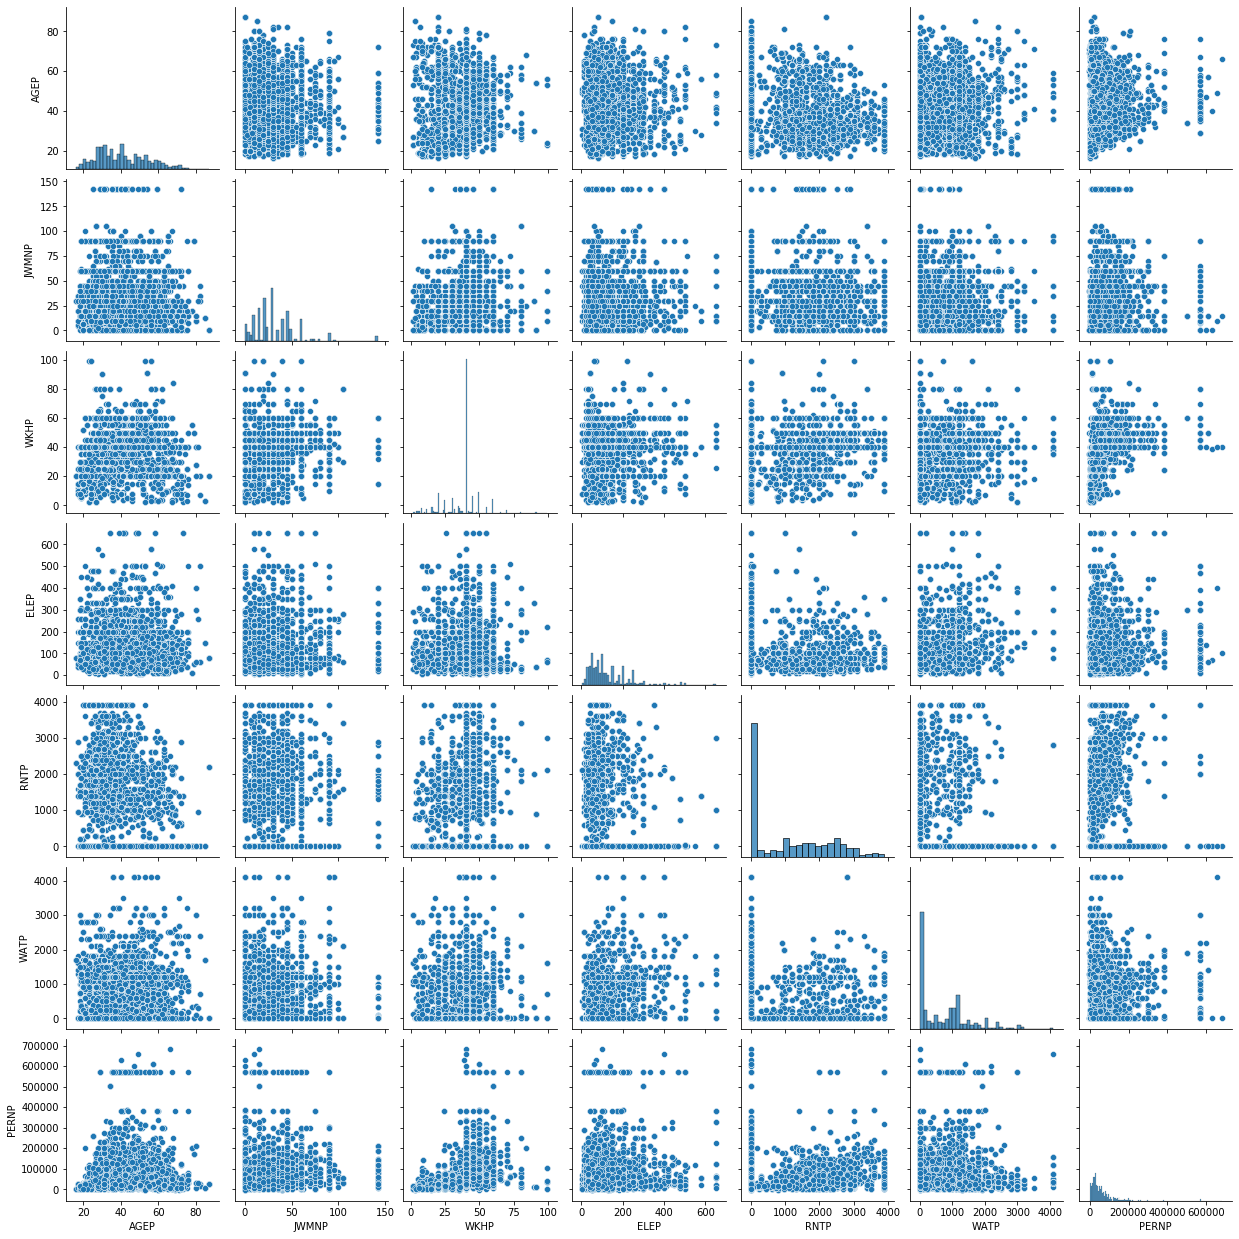

In [75]:
sns.pairplot(numerical.sample(10000))

checking for colinearity

In [76]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [77]:
calc_vif(numerical)

,variables,VIF
0,AGEP,6.617596
1,JWMNP,2.514238
2,WKHP,8.321029
3,ELEP,2.843827
4,RNTP,1.937197
5,WATP,2.022738
6,PERNP,2.009440


In [78]:
cat = df.loc[:,['PUMA', 'ESR', 'JWTRNS', 'FER', 'MIL', 'SEX', 'SCHL', 'DIS', 'HICOV', 'ACCESS']].copy()
for col in cat:
    cat[col] = cat[col].astype('category')
df_cat = pd.get_dummies(cat, drop_first = True)
df = pd.concat([numerical, df_cat, y], axis = 1, join = "inner")

In [79]:
# split 70-30
df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100, shuffle = True)
#rescale
scaler = MinMaxScaler()
nu_var = ['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']
df_train[nu_var] = scaler.fit_transform(df_train[nu_var])
#rescale testset
df_test[nu_var] = scaler.fit_transform(df_test[nu_var])
y_train = df_train.pop('ASSISTANCE')
X_train = df_train
y_test = df_test.pop('ASSISTANCE')
X_test = df_test

#### RFE feature selection

In [80]:
# create a cv scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

#range of hypermeters
hyper_params = [{'n_features_to_select': list(range(1,53))}]

# grid search
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)

model_cv = GridSearchCV(estimator = rfe, param_grid = hyper_params, scoring= 'r2', cv = folds, verbose = 1, return_train_score=True)
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 52 candidates, totalling 260 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28, 29, 30, ...]}],
             return_train_score=True, scoring='r2', verbose=1)

In [81]:
cv_result = pd.DataFrame(model_cv.cv_results_)
cv_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,3.734982,0.130954,0.006184,9.773890e-04,1,{'n_features_to_select': 1},0.002595,0.003126,0.002156,0.003631,...,0.003103,0.000670,52,0.002010,0.004027,0.002114,0.003903,0.003809,0.003173,0.000910
1,3.647018,0.263065,0.005784,3.988267e-04,2,{'n_features_to_select': 2},0.003937,0.006507,0.003728,0.007096,...,0.005724,0.001571,51,0.003552,0.007609,0.003599,0.007464,0.007399,0.005925,0.001919
2,3.826929,0.082224,0.006583,1.352698e-03,3,{'n_features_to_select': 3},0.007860,0.006507,0.008038,0.007096,...,0.007371,0.000549,49,0.007270,0.007609,0.007217,0.007464,0.007399,0.007392,0.000140
3,4.444429,0.272983,0.006962,2.005283e-03,4,{'n_features_to_select': 4},0.007858,0.006491,0.007998,0.007096,...,0.007357,0.000544,50,0.007270,0.007606,0.007211,0.007460,0.007389,0.007387,0.000140
4,4.040355,0.416232,0.006581,7.953654e-04,5,{'n_features_to_select': 5},0.099239,0.097572,0.096503,0.094575,...,0.097499,0.001844,48,0.097062,0.097490,0.097760,0.098240,0.096963,0.097503,0.000468
5,4.453240,0.421916,0.006686,8.689814e-04,6,{'n_features_to_select': 6},0.099640,0.097949,0.096611,0.095159,...,0.097847,0.001794,47,0.097375,0.097839,0.098172,0.098533,0.097338,0.097852,0.000460
6,3.956887,0.372668,0.006488,6.314359e-04,7,{'n_features_to_select': 7},0.100282,0.098253,0.096950,0.095843,...,0.098413,0.001880,46,0.097952,0.098460,0.098783,0.099062,0.097823,0.098416,0.000473
7,3.666724,0.058356,0.006782,3.989459e-04,8,{'n_features_to_select': 8},0.100352,0.098386,0.097256,0.095929,...,0.098568,0.001867,45,0.098115,0.098625,0.098904,0.099236,0.097982,0.098572,0.000471
8,4.610500,0.098150,0.008195,4.089130e-04,9,{'n_features_to_select': 9},0.101333,0.099327,0.098155,0.096956,...,0.099458,0.001774,44,0.098971,0.099507,0.099793,0.100093,0.098942,0.099461,0.000452
9,4.760625,0.116249,0.007585,7.972277e-04,10,{'n_features_to_select': 10},0.103453,0.101397,0.100609,0.098538,...,0.101482,0.001846,43,0.101000,0.101523,0.101703,0.102232,0.101006,0.101493,0.000463


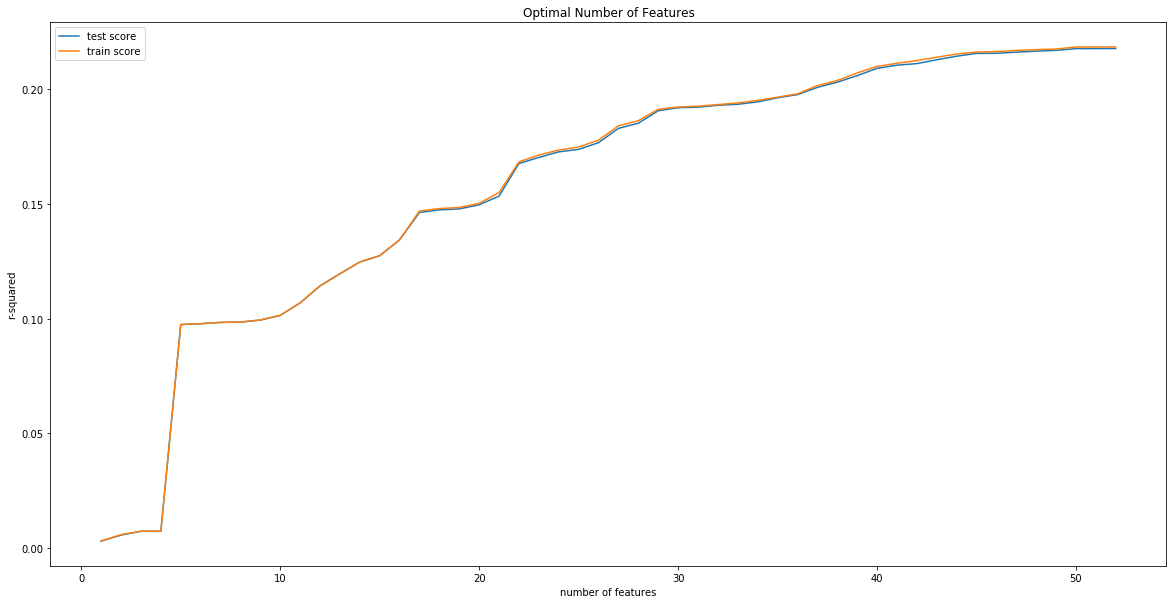

In [82]:
# plotting cv results
plt.figure(figsize=(20,10))

plt.plot(cv_result["param_n_features_to_select"], cv_result["mean_test_score"])
plt.plot(cv_result["param_n_features_to_select"], cv_result["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

#### Decision Tree feature selection

In [83]:
y = df["ASSISTANCE"]
X = df.drop(columns="ASSISTANCE")

In [84]:
dt = DecisionTreeClassifier(random_state=15, criterion = 'entropy', max_depth = 10)
dt.fit(X,y)

fi_col = []
fi = []

for i,column in enumerate(df.drop(['ASSISTANCE'], axis = 'columns')):
    print('The feature importance for {} is : {}'.format(column, dt.feature_importances_[i]))
    
    fi_col.append(column)
    fi.append(dt.feature_importances_[i])

The feature importance for AGEP is : 0.14019968310348113
The feature importance for JWMNP is : 0.048658125406750685
The feature importance for WKHP is : 0.04323782075968515
The feature importance for ELEP is : 0.13462534806103174
The feature importance for RNTP is : 0.08781769761711562
The feature importance for WATP is : 0.1474686741642805
The feature importance for PERNP is : 0.2344021580815597
The feature importance for PUMA_103 is : 0.003122376727532429
The feature importance for PUMA_104 is : 0.009551691893700465
The feature importance for PUMA_105 is : 0.003833008480075287
The feature importance for ESR_4.0 is : 0.0
The feature importance for JWTRNS_2.0 is : 0.0
The feature importance for JWTRNS_3.0 is : 0.0
The feature importance for JWTRNS_4.0 is : 0.0
The feature importance for JWTRNS_5.0 is : 0.0
The feature importance for JWTRNS_6.0 is : 0.0
The feature importance for JWTRNS_7.0 is : 0.0
The feature importance for JWTRNS_8.0 is : 0.0
The feature importance for JWTRNS_9.0 is 

In [85]:
fi_df = zip(fi_col, fi)
fi_df = pd.DataFrame(fi_df, columns = ['Feature','Feature Importance'])
fi_df


# Ordering the data
fi_df = fi_df.sort_values('Feature Importance', ascending = False).reset_index()
fi_df = fi_df[fi_df["Feature Importance"] > 0]
fi_df

,index,Feature,Feature Importance
0,6,PERNP,0.234402
1,5,WATP,0.147469
2,0,AGEP,0.140200
3,3,ELEP,0.134625
4,4,RNTP,0.087818
5,1,JWMNP,0.048658
6,2,WKHP,0.043238
7,44,SCHL_21.0,0.020268
8,39,SCHL_16.0,0.016667
9,42,SCHL_19.0,0.016152


In [86]:
selected = ["PERNP", "ELEP", "RNTP", "WATP", "JWMNP", "AGEP", "WKHP", "SCHL", "PUMA", "FER", "SEX", "JWTRNS"]

#### remove outliers

In [87]:
def remOutliers(df, cat, y):
    for col in df.columns:
        if (col not in cat) and (col != y):
            #print("DataFrame starting size " + str(len(df)))
            #print(col + " outliers being removed... ")
            mean = np.mean(df[col], axis=0)
            sd = np.std(df[col], axis=0)
            df = df[df[col] > mean - (2*sd)].copy()
            df = df[df[col] < mean + (2*sd)].copy()
            #print("DataFrame new size " + str(len(df)))
        else:
            #print(col + " is not a numerical feature, skipping... ")
            pass
    return df

#### First model

Counter({0.0: 167472, 1.0: 8351})
Counter({0.0: 167472, 1.0: 16747})
Counter({0.0: 33494, 1.0: 16747})
[[8835 1228]
 [2295 2715]]
              precision    recall  f1-score   support

         0.0       0.79      0.88      0.83     10063
         1.0       0.69      0.54      0.61      5010

    accuracy                           0.77     15073
   macro avg       0.74      0.71      0.72     15073
weighted avg       0.76      0.77      0.76     15073

0.7099424821231035
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.710


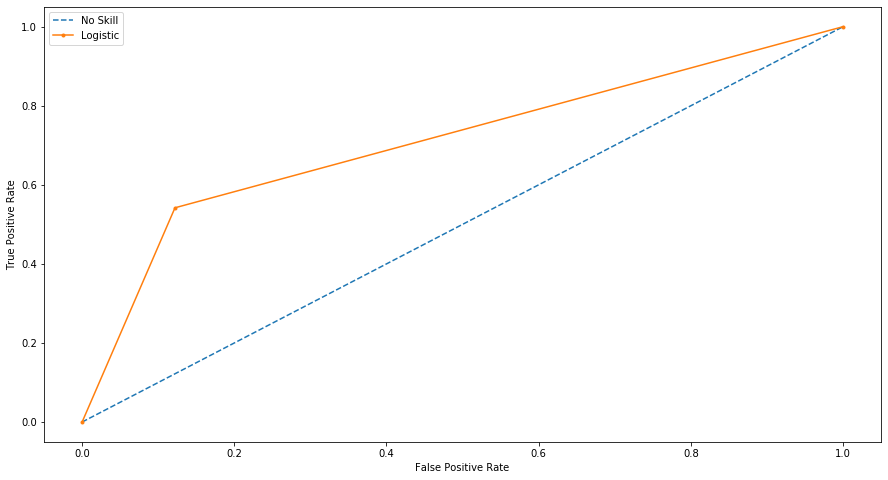

In [89]:
df = pca191_Ok.loc[:, ['PUMA', 'RELSHIPP', "AGEP", 'ESR', 'FER', 'JWMNP', 'JWTRNS', 'MIL', 'SCHL', 'SEX', "DIS",'HICOV', 'WKHP', 'ACCESS', 'ELEP', 'FULP', 'GASP', 'RNTP', 'WATP', 'PERNP', 'FS', 'FFSP', 'HINS4', 'PAP']].copy()
#Make new calculated column for dependent variable
df.loc[(df.FS == 1) | (df.FFSP == 1)| (df.HINS4 == 1) | (df.PAP > 0), "ASSISTANCE"] = 1
df.ASSISTANCE = df.ASSISTANCE.fillna(0)
#drop columns used to calculate predictor
df = df.drop(columns=['FS', 'FFSP', 'HINS4', 'PAP']).copy()

#Get rid of people not in the labor force and  people under 16
df = df.loc[(df.ESR != 6) & (df.AGEP >= 16)].copy()

df.FER = df.FER.fillna(2).copy()
df.JWMNP = df.JWMNP.fillna(0).copy()
df.WKHP = df.WKHP.fillna(0).copy()
df.RNTP = df.RNTP.fillna(0).copy()
df.WATP = df.WATP.fillna(0).copy()
df.MIL = df.MIL.fillna(4).copy()
df = df.loc[(df['ELEP'].notna()) & (df['JWTRNS'].notna())]
df = df.drop(columns=['FULP', 'GASP']).copy()

numericalCols = ['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']
catCols = ['PUMA', 'JWTRNS', 'FER', 'SEX', 'SCHL']

df = remOutliers(df, catCols, df.ASSISTANCE.name)
y = df["ASSISTANCE"]
X = df[selected]

# summarize class distribution
print(Counter(y))
# define oversampling strategy
over = RandomOverSampler(sampling_strategy=0.1)
# fit and apply the transform
X, y = over.fit_resample(X, y)
# summarize class distribution
print(Counter(y))
# define undersampling strategy
under = RandomUnderSampler(sampling_strategy=0.5)
# fit and apply the transform
X, y = under.fit_resample(X, y)
# summarize class distribution
print(Counter(y))

df = pd.concat([y,X], axis = 1, join = "inner")

numerical = df.loc[:,['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']].copy()
cat = df.loc[:,['PUMA', 'JWTRNS', 'FER', 'SEX', 'SCHL']].copy()
for col in cat:
    cat[col] = cat[col].astype('category')
    
df_cat = pd.get_dummies(cat, drop_first = True)
df = pd.concat([numerical, df_cat, y], axis = 1, join = "inner")

# split 70-30
df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100, shuffle = True)

#rescale
scaler = MinMaxScaler()
nu_var = ['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']
df_train[nu_var] = scaler.fit_transform(df_train[nu_var])
#rescale testset
df_test[nu_var] = scaler.fit_transform(df_test[nu_var])
y_train = df_train.pop('ASSISTANCE')
X_train = df_train
y_test = df_test.pop('ASSISTANCE')
X_test = df_test

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

ns_probs = [0 for _ in range(len(y_test))]

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(balanced_accuracy_score(y_test,y_pred))
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, y_pred)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred)

# plot the roc curve for the model
fig = plt.figure(figsize = (15,8))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

#### Regularization (L1)

In [90]:
df = pca191_Ok.loc[:, ['PUMA', 'RELSHIPP', "AGEP", 'ESR', 'FER', 'JWMNP', 'JWTRNS', 'MIL', 'SCHL', 'SEX', "DIS",'HICOV', 'WKHP', 'ACCESS', 'ELEP', 'FULP', 'GASP', 'RNTP', 'WATP', 'PERNP', 'FS', 'FFSP', 'HINS4', 'PAP']].copy()
#Make new calculated column for dependent variable
df.loc[(df.FS == 1) | (df.FFSP == 1)| (df.HINS4 == 1) | (df.PAP > 0), "ASSISTANCE"] = 1
df.ASSISTANCE = df.ASSISTANCE.fillna(0)
#drop columns used to calculate predictor
df = df.drop(columns=['FS', 'FFSP', 'HINS4', 'PAP']).copy()

#Get rid of people not in the labor force and  people under 16
df = df.loc[(df.ESR != 6) & (df.AGEP >= 16)].copy()

df.FER = df.FER.fillna(2).copy()
df.JWMNP = df.JWMNP.fillna(0).copy()
df.WKHP = df.WKHP.fillna(0).copy()
df.RNTP = df.RNTP.fillna(0).copy()
df.WATP = df.WATP.fillna(0).copy()
df.MIL = df.MIL.fillna(4).copy()
df = df.loc[(df['ELEP'].notna()) & (df['JWTRNS'].notna())]
df = df.drop(columns=['FULP', 'GASP']).copy()

numericalCols = ['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']
catCols = ['PUMA', 'ESR', 'JWTRNS', 'FER', 'MIL', 'SEX', 'SCHL', 'DIS', 'HICOV', 'ACCESS']

df = remOutliers(df, catCols, df.ASSISTANCE.name)

y = df["ASSISTANCE"]
X = df.drop(columns="ASSISTANCE")

# summarize class distribution
print(Counter(y))
o = 0.9
u = 0.9
# define oversampling strategy
over = RandomOverSampler(sampling_strategy=o)
# fit and apply the transform
X, y = over.fit_resample(X, y)
# summarize class distribution
print(Counter(y))
# define undersampling strategy
under = RandomUnderSampler(sampling_strategy=u)
# fit and apply the transform
X, y = under.fit_resample(X, y)
# summarize class distribution
print(Counter(y))

df = pd.concat([y,X], axis = 1, join = "inner")

numerical = df.loc[:,['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']].copy()
cat = df.loc[:,['PUMA', 'ESR', 'JWTRNS', 'FER', 'MIL', 'SEX', 'SCHL', 'DIS', 'HICOV', 'ACESS']].copy()
for col in cat:
    cat[col] = cat[col].astype('category')
    
df_cat = pd.get_dummies(cat, drop_first = True)
df = pd.concat([numerical, df_cat, y], axis = 1, join = "inner")

# split 70-30
df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100, shuffle = True)

#rescale
scaler = MinMaxScaler()
nu_var = ['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']
df_train[nu_var] = scaler.fit_transform(df_train[nu_var])
#rescale testset
df_test[nu_var] = scaler.fit_transform(df_test[nu_var])
y_train = df_train.pop('ASSISTANCE')
X_train = df_train
y_test = df_test.pop('ASSISTANCE')
X_test = df_test

# Create a scaler object
sc = StandardScaler()

# Fit the scaler to the training data and transform
X_train_std = sc.fit_transform(X_train)

# Apply the scaler to the test data
X_test_std = sc.transform(X_test)

C = [10, 1, .1, .001]

for c in C:
    clf = LogisticRegression(penalty='l1', C=c, solver='liblinear')
    clf.fit(X_train, y_train)
    print('C:', c)
    print('Coefficient of each feature:', clf.coef_)
    print('Training accuracy:', clf.score(X_train_std, y_train))
    print('Test accuracy:', clf.score(X_test_std, y_test))
    print('')

Counter({0.0: 194867, 1.0: 11248})
Counter({0.0: 194867, 1.0: 175380})
Counter({0.0: 194866, 1.0: 175380})
C: 10
Coefficient of each feature: [[ -0.74956192   0.33455542   0.40323064   0.82770866   0.54295512
    0.45101831  -2.71782868  -1.09499271  -0.79348263  -0.18422892
   -6.85314539   0.67040557  -0.44811694  -0.2356802   -8.01060232
   -9.12031612  -0.14715049  -8.60716219   0.74365737  -1.7911319
   -0.56618875  -0.19836803  -1.47551131   2.88411091  -7.05442655
    1.69986816   0.45840618  -0.52927768  -9.16401854  -7.8374381
   -0.09242488 -10.31949778   0.3874558   -0.26543007 -10.49045128
    0.08009789  -0.85536471  -1.13321603  -2.44824969  -1.04324164
   -1.35346754  -1.71601562  -2.44329235  -2.06140438  -1.9933904
   -2.69841594  -0.16821731   0.57193709]]
Training accuracy: 0.6212592409673885
Test accuracy: 0.6209463960962962

C: 1
Coefficient of each feature: [[-0.74945289  0.33269934  0.40012202  0.82670538  0.54355717  0.45186483
  -2.71673317 -1.09446216 -0.79260

#### L1 with feature importance

In [91]:
df = pca191_Ok.loc[:, ['PUMA', 'RELSHIPP', "AGEP", 'ESR', 'FER', 'JWMNP', 'JWTRNS', 'MIL', 'SCHL', 'SEX', "DIS",'HICOV', 'WKHP', 'ACCESS', 'ELEP', 'FULP', 'GASP', 'RNTP', 'WATP', 'PERNP', 'FS', 'FFSP', 'HINS4', 'PAP']].copy()
#Make new calculated column for dependent variable
df.loc[(df.FS == 1) | (df.FFSP == 1)| (df.HINS4 == 1) | (df.PAP > 0), "ASSISTANCE"] = 1
df.ASSISTANCE = df.ASSISTANCE.fillna(0)
#drop columns used to calculate predictor
df = df.drop(columns=['FS', 'FFSP', 'HINS4', 'PAP']).copy()

#Get rid of people not in the labor force and  people under 16
df = df.loc[(df.ESR != 6) & (df.AGEP >= 16)].copy()

df.FER = df.FER.fillna(2).copy()
df.JWMNP = df.JWMNP.fillna(0).copy()
df.WKHP = df.WKHP.fillna(0).copy()
df.RNTP = df.RNTP.fillna(0).copy()
df.WATP = df.WATP.fillna(0).copy()
df.MIL = df.MIL.fillna(4).copy()
df = df.loc[(df['ELEP'].notna()) & (df['JWTRNS'].notna())]
df = df.drop(columns=['FULP', 'GASP']).copy()

numericalCols = ['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']
catCols = ['PUMA', 'ESR', 'JWTRNS', 'FER', 'MIL', 'SEX', 'SCHL', 'DIS', 'HICOV', 'ACCESS']

df = remOutliers(df, catCols, df.ASSISTANCE.name)

y = df["ASSISTANCE"]
X = df.drop(columns="ASSISTANCE")

# summarize class distribution
print(Counter(y))
o = 0.9
u = 0.9
# define oversampling strategy
over = RandomOverSampler(sampling_strategy=o)
# fit and apply the transform
X, y = over.fit_resample(X, y)
# summarize class distribution
print(Counter(y))
# define undersampling strategy
under = RandomUnderSampler(sampling_strategy=u)
# fit and apply the transform
X, y = under.fit_resample(X, y)
# summarize class distribution
print(Counter(y))

df = pd.concat([y,X], axis = 1, join = "inner")

numerical = df.loc[:,['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']].copy()
cat = df.loc[:,['PUMA', 'JWTRNS', 'FER', 'SEX', 'SCHL']].copy()
for col in cat:
    cat[col] = cat[col].astype('category')
    
df_cat = pd.get_dummies(cat, drop_first = True)
df = pd.concat([numerical, df_cat, y], axis = 1, join = "inner")

# split 70-30
df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100, shuffle = True)

#rescale
scaler = MinMaxScaler()
nu_var = ['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']
df_train[nu_var] = scaler.fit_transform(df_train[nu_var])
#rescale testset
df_test[nu_var] = scaler.fit_transform(df_test[nu_var])
y_train = df_train.pop('ASSISTANCE')
X_train = df_train
y_test = df_test.pop('ASSISTANCE')
X_test = df_test

# Create a scaler object
sc = StandardScaler()

# Fit the scaler to the training data and transform
X_train_std = sc.fit_transform(X_train)

# Apply the scaler to the test data
X_test_std = sc.transform(X_test)

C = [10, 1, .1, .001]

for c in C:
    clf = LogisticRegression(penalty='l1', C=c, solver='liblinear')
    clf.fit(X_train, y_train)
    print('C:', c)
    print('Coefficient of each feature:', clf.coef_)
    print('Training accuracy:', clf.score(X_train_std, y_train))
    print('Test accuracy:', clf.score(X_test_std, y_test))
    print('')

Counter({0.0: 194867, 1.0: 11248})
Counter({0.0: 194867, 1.0: 175380})
Counter({0.0: 194866, 1.0: 175380})
C: 10
Coefficient of each feature: [[ -0.57286068   0.39302879   0.64612903   0.66013935   0.6385483
    0.66613892  -2.95679994  -1.11866272  -0.83840372  -0.1662141
    0.68606161  -0.4617815   -0.26407792  -8.20380393  -9.22487106
   -0.432722    -8.58894557   0.71362639  -1.85825741  -0.51352627
   -0.15080738  -1.58801104   0.426809    -0.75471848  -9.21669563
   -7.88366715  -0.20694491  -9.9161123    0.20333956  -0.53508671
  -10.6046954    0.03303163  -0.94807414  -1.14281429  -2.50985196
   -1.07798708  -1.46733398  -1.77592912  -2.49474049  -2.19659184
   -2.13389593  -2.75510456]]
Training accuracy: 0.6005124010309756
Test accuracy: 0.6013558528548535

C: 1
Coefficient of each feature: [[-0.57301508  0.39106746  0.64319239  0.65917644  0.63898745  0.66687272
  -2.95563629 -1.11807976 -0.83735967 -0.16532297  0.68602488 -0.46024901
  -0.26082451 -5.89838733 -6.9214309  -

#### L2 with feature importance

In [92]:
df = pca191_Ok.loc[:, ['PUMA', 'RELSHIPP', "AGEP", 'ESR', 'FER', 'JWMNP', 'JWTRNS', 'MIL', 'SCHL', 'SEX', "DIS",'HICOV', 'WKHP', 'ACCESS', 'ELEP', 'FULP', 'GASP', 'RNTP', 'WATP', 'PERNP', 'FS', 'FFSP', 'HINS4', 'PAP']].copy()
#Make new calculated column for dependent variable
df.loc[(df.FS == 1) | (df.FFSP == 1)| (df.HINS4 == 1) | (df.PAP > 0), "ASSISTANCE"] = 1
df.ASSISTANCE = df.ASSISTANCE.fillna(0)
#drop columns used to calculate predictor
df = df.drop(columns=['FS', 'FFSP', 'HINS4', 'PAP']).copy()

#Get rid of people not in the labor force and  people under 16
df = df.loc[(df.ESR != 6) & (df.AGEP >= 16)].copy()

df.FER = df.FER.fillna(2).copy()
df.JWMNP = df.JWMNP.fillna(0).copy()
df.WKHP = df.WKHP.fillna(0).copy()
df.RNTP = df.RNTP.fillna(0).copy()
df.WATP = df.WATP.fillna(0).copy()
df.MIL = df.MIL.fillna(4).copy()
df = df.loc[(df['ELEP'].notna()) & (df['JWTRNS'].notna())]
df = df.drop(columns=['FULP', 'GASP']).copy()

numericalCols = ['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']
catCols = ['PUMA', 'ESR', 'JWTRNS', 'FER', 'MIL', 'SEX', 'SCHL', 'DIS', 'HICOV', 'ACCESS']

df = remOutliers(df, catCols, df.ASSISTANCE.name)

y = df["ASSISTANCE"]
X = df.drop(columns="ASSISTANCE")

# summarize class distribution
print(Counter(y))
o = 0.3
u = 0.9
# define oversampling strategy
over = RandomOverSampler(sampling_strategy=o)
# fit and apply the transform
X, y = over.fit_resample(X, y)
# summarize class distribution
print(Counter(y))
# define undersampling strategy
under = RandomUnderSampler(sampling_strategy=u)
# fit and apply the transform
X, y = under.fit_resample(X, y)
# summarize class distribution
print(Counter(y))

df = pd.concat([y,X], axis = 1, join = "inner")

numerical = df.loc[:,['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']].copy()
cat = df.loc[:,['PUMA', 'JWTRNS', 'FER', 'SEX', 'SCHL']].copy()
for col in cat:
    cat[col] = cat[col].astype('category')
    
df_cat = pd.get_dummies(cat, drop_first = True)
df = pd.concat([numerical, df_cat, y], axis = 1, join = "inner")

# split 70-30
df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100, shuffle = True)

#rescale
scaler = MinMaxScaler()
nu_var = ['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']
df_train[nu_var] = scaler.fit_transform(df_train[nu_var])
#rescale testset
df_test[nu_var] = scaler.fit_transform(df_test[nu_var])
y_train = df_train.pop('ASSISTANCE')
X_train = df_train
y_test = df_test.pop('ASSISTANCE')
X_test = df_test

# Create a scaler object
sc = StandardScaler()

# Fit the scaler to the training data and transform
X_train_std = sc.fit_transform(X_train)

# Apply the scaler to the test data
X_test_std = sc.transform(X_test)

C = [10, 1, .1, .001, 0.0001]

for c in C:
    clf = LogisticRegression(penalty='l2', C=c, solver='newton-cg')
    clf.fit(X_train, y_train)
    print('C:', c)
    print('Coefficient of each feature:', clf.coef_)
    print('Training accuracy:', clf.score(X_train_std, y_train))
    print('Test accuracy:', clf.score(X_test_std, y_test))
    print('')

Counter({0.0: 194867, 1.0: 11248})
Counter({0.0: 194867, 1.0: 58460})
Counter({0.0: 64955, 1.0: 58460})
C: 10
Coefficient of each feature: [[-0.53261456  0.39879514  0.63952524  0.66727839  0.67385645  0.68936155
  -2.94447601 -1.04670773 -0.81323925 -0.15567542  0.718692   -0.46997869
  -0.22042009 -5.43677885 -6.24534615 -0.44049602 -5.79984043  0.73543902
  -1.80735482 -0.5047967  -0.31478059 -1.66301923  0.44181357 -0.56978847
  -6.31734034 -5.154869   -0.24757273 -7.00389557  0.14008812 -0.54866645
  -7.4457796  -0.02204505 -1.00524896 -1.1291228  -2.56250168 -1.06126369
  -1.45926028 -1.80624885 -2.4811553  -2.23083798 -2.14060002 -2.82818319]]
Training accuracy: 0.6155805070031254
Test accuracy: 0.6148278190411884

C: 1
Coefficient of each feature: [[-0.53625275  0.38420626  0.62501019  0.66444767  0.67947301  0.69703177
  -2.93627531 -1.04554411 -0.81044704 -0.1520355   0.71860038 -0.46209371
  -0.21504247 -3.53814806 -4.30463209 -0.44412935 -3.86957354  0.72943022
  -1.7918327

#### Over Under Loop with feature important (L2)

In [93]:
df = pca191_Ok.loc[:, ['PUMA', 'RELSHIPP', "AGEP", 'ESR', 'FER', 'JWMNP', 'JWTRNS', 'MIL', 'SCHL', 'SEX', "DIS",'HICOV', 'WKHP', 'ACCESS', 'ELEP', 'FULP', 'GASP', 'RNTP', 'WATP', 'PERNP', 'FS', 'FFSP', 'HINS4', 'PAP']].copy()
#Make new calculated column for dependent variable
df.loc[(df.FS == 1) | (df.FFSP == 1)| (df.HINS4 == 1) | (df.PAP > 0), "ASSISTANCE"] = 1
df.ASSISTANCE = df.ASSISTANCE.fillna(0)
#drop columns used to calculate predictor
df = df.drop(columns=['FS', 'FFSP', 'HINS4', 'PAP']).copy()

#Get rid of people not in the labor force and  people under 16
df = df.loc[(df.ESR != 6) & (df.AGEP >= 16)].copy()

df.FER = df.FER.fillna(2).copy()
df.JWMNP = df.JWMNP.fillna(0).copy()
df.WKHP = df.WKHP.fillna(0).copy()
df.RNTP = df.RNTP.fillna(0).copy()
df.WATP = df.WATP.fillna(0).copy()
df.MIL = df.MIL.fillna(4).copy()
df = df.loc[(df['ELEP'].notna()) & (df['JWTRNS'].notna())]
df = df.drop(columns=['FULP', 'GASP']).copy()

numericalCols = ['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']
catCols = ['PUMA', 'ESR', 'JWTRNS', 'FER', 'MIL', 'SEX', 'SCHL', 'DIS', 'HICOV', 'ACCESS']

df = remOutliers(df, catCols, df.ASSISTANCE.name)

y_main = df["ASSISTANCE"]
X_main = df.drop(columns="ASSISTANCE")

oversampling = []
undersampling = []
balanced_acc = []

for i in range(3,11):
    i = i*0.1
    for j in range(3,11):
        j = j*0.1
    
        o = i
        u = j
        # define oversampling strategy
        over = RandomOverSampler(sampling_strategy=o)
        # fit and apply the transform
        X, y = over.fit_resample(X_main, y_main)
        # define undersampling strategy
        under = RandomUnderSampler(sampling_strategy=u)
        # fit and apply the transform
        X, y = under.fit_resample(X_main, y_main)
    
        df = pd.concat([y,X], axis = 1, join = "inner")
    
        numerical = df.loc[:,['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']].copy()
        cat = df.loc[:,['PUMA', 'JWTRNS', 'FER', 'SEX', 'SCHL']].copy()
        for col in cat:
            cat[col] = cat[col].astype('category')
    
        df_cat = pd.get_dummies(cat, drop_first = True)
        df = pd.concat([numerical, df_cat, y], axis = 1, join = "inner")

        # split 70-30
        df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100, shuffle = True)

        #rescale
        scaler = MinMaxScaler()
        nu_var = ['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']
        df_train[nu_var] = scaler.fit_transform(df_train[nu_var])
        #rescale testset
        df_test[nu_var] = scaler.fit_transform(df_test[nu_var])
        y_train = df_train.pop('ASSISTANCE')
        X_train = df_train
        y_test = df_test.pop('ASSISTANCE')
        X_test = df_test

        # Create a scaler object
        sc = StandardScaler()

        # Fit the scaler to the training data and transform
        X_train_std = sc.fit_transform(X_train)

        # Apply the scaler to the test data
        X_test_std = sc.transform(X_test)
    
        c = 0.001
        logreg = LogisticRegression(penalty='l2', C=c, solver='newton-cg')
        logreg.fit(X_train_std, y_train)
        y_pred = logreg.predict(X_test_std)
        b_acc = balanced_accuracy_score(y_test,y_pred)

        oversampling.append(i)
        undersampling.append(j)
        balanced_acc.append(b_acc)
    

In [94]:
dfx = pd.DataFrame(list(zip(oversampling, undersampling, balanced_acc)),
               columns =['oversampling', 'undersampling', 'balanced_acc'])
dfx = dfx.sort_values('balanced_acc', ascending = False).reset_index(drop = True)
dfx

,oversampling,undersampling,balanced_acc
0,0.7,0.7,0.757915
1,0.3,0.9,0.754040
2,0.7,0.9,0.752454
3,0.9,1.0,0.752062
4,1.0,0.9,0.751748
...,...,...,...
59,0.7,0.3,0.600574
60,0.8,0.3,0.599357
61,0.5,0.3,0.599090
62,1.0,0.3,0.598290


#### Over Under Loop with feature important w/o Reg

In [95]:
df = pca191_Ok.loc[:, ['PUMA', 'RELSHIPP', "AGEP", 'ESR', 'FER', 'JWMNP', 'JWTRNS', 'MIL', 'SCHL', 'SEX', "DIS",'HICOV', 'WKHP', 'ACCESS', 'ELEP', 'FULP', 'GASP', 'RNTP', 'WATP', 'PERNP', 'FS', 'FFSP', 'HINS4', 'PAP']].copy()
#Make new calculated column for dependent variable
df.loc[(df.FS == 1) | (df.FFSP == 1)| (df.HINS4 == 1) | (df.PAP > 0), "ASSISTANCE"] = 1
df.ASSISTANCE = df.ASSISTANCE.fillna(0)
#drop columns used to calculate predictor
df = df.drop(columns=['FS', 'FFSP', 'HINS4', 'PAP']).copy()

#Get rid of people not in the labor force and  people under 16
df = df.loc[(df.ESR != 6) & (df.AGEP >= 16)].copy()

df.FER = df.FER.fillna(2).copy()
df.JWMNP = df.JWMNP.fillna(0).copy()
df.WKHP = df.WKHP.fillna(0).copy()
df.RNTP = df.RNTP.fillna(0).copy()
df.WATP = df.WATP.fillna(0).copy()
df.MIL = df.MIL.fillna(4).copy()
df = df.loc[(df['ELEP'].notna()) & (df['JWTRNS'].notna())]
df = df.drop(columns=['FULP', 'GASP']).copy()

numericalCols = ['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']
catCols = ['PUMA', 'ESR', 'JWTRNS', 'FER', 'MIL', 'SEX', 'SCHL', 'DIS', 'HICOV', 'ACCESS']

df = remOutliers(df, catCols, df.ASSISTANCE.name)

y_main = df["ASSISTANCE"]
X_main = df.drop(columns="ASSISTANCE")

oversampling = []
undersampling = []
balanced_acc = []

for i in range(3,11):
    i = i*0.1
    for j in range(3,11):
        j = j*0.1
    
        o = i
        u = j
        # define oversampling strategy
        over = RandomOverSampler(sampling_strategy=o)
        # fit and apply the transform
        X, y = over.fit_resample(X_main, y_main)
        # define undersampling strategy
        under = RandomUnderSampler(sampling_strategy=u)
        # fit and apply the transform
        X, y = under.fit_resample(X_main, y_main)
    
        df = pd.concat([y,X], axis = 1, join = "inner")
    
        numerical = df.loc[:,['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']].copy()
        cat = df.loc[:,['PUMA', 'JWTRNS', 'FER', 'SEX', 'SCHL']].copy()
        for col in cat:
            cat[col] = cat[col].astype('category')
    
        df_cat = pd.get_dummies(cat, drop_first = True)
        df = pd.concat([numerical, df_cat, y], axis = 1, join = "inner")

        # split 70-30
        df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100, shuffle = True)

        #rescale
        scaler = MinMaxScaler()
        nu_var = ['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']
        df_train[nu_var] = scaler.fit_transform(df_train[nu_var])
        #rescale testset
        df_test[nu_var] = scaler.fit_transform(df_test[nu_var])
        y_train = df_train.pop('ASSISTANCE')
        X_train = df_train
        y_test = df_test.pop('ASSISTANCE')
        X_test = df_test

        # Create a scaler object
        sc = StandardScaler()

        # Fit the scaler to the training data and transform
        X_train_std = sc.fit_transform(X_train)

        # Apply the scaler to the test data
        X_test_std = sc.transform(X_test)
    
        c = 0.001
        logreg = LogisticRegression()
        logreg.fit(X_train, y_train)
        y_pred = logreg.predict(X_test)
        b_acc = balanced_accuracy_score(y_test,y_pred)

        oversampling.append(i)
        undersampling.append(j)
        balanced_acc.append(b_acc)
    

In [96]:
dfx = pd.DataFrame(list(zip(oversampling, undersampling, balanced_acc)),
               columns =['oversampling', 'undersampling', 'balanced_acc'])
dfx = dfx.sort_values('balanced_acc', ascending = False).reset_index(drop = True)
dfx

,oversampling,undersampling,balanced_acc
0,0.9,0.7,0.765564
1,0.8,0.7,0.764055
2,1.0,0.7,0.762041
3,0.4,0.7,0.761338
4,0.3,1.0,0.760841
...,...,...,...
59,0.9,0.3,0.650096
60,0.5,0.3,0.648880
61,0.8,0.3,0.648791
62,1.0,0.3,0.646743


#### Over Under Loop with all feature(w/o FER) w/o Reg

In [97]:
df = pca191_Ok.loc[:, ['PUMA', 'RELSHIPP', "AGEP", 'ESR', 'FER', 'JWMNP', 'JWTRNS', 'MIL', 'SCHL', 'SEX', "DIS",'HICOV', 'WKHP', 'ACCESS', 'ELEP', 'FULP', 'GASP', 'RNTP', 'WATP', 'PERNP', 'FS', 'FFSP', 'HINS4', 'PAP']].copy()
#Make new calculated column for dependent variable
df.loc[(df.FS == 1) | (df.FFSP == 1)| (df.HINS4 == 1) | (df.PAP > 0), "ASSISTANCE"] = 1
df.ASSISTANCE = df.ASSISTANCE.fillna(0)
#drop columns used to calculate predictor
df = df.drop(columns=['FS', 'FFSP', 'HINS4', 'PAP']).copy()

#Get rid of people not in the labor force and  people under 16
df = df.loc[(df.ESR != 6) & (df.AGEP >= 16)].copy()

df.FER = df.FER.fillna(2).copy()
df.JWMNP = df.JWMNP.fillna(0).copy()
df.WKHP = df.WKHP.fillna(0).copy()
df.RNTP = df.RNTP.fillna(0).copy()
df.WATP = df.WATP.fillna(0).copy()
df.MIL = df.MIL.fillna(4).copy()
df = df.loc[(df['ELEP'].notna()) & (df['JWTRNS'].notna())]
df = df.drop(columns=['FULP', 'GASP']).copy()

numericalCols = ['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']
catCols = ['PUMA', 'ESR', 'JWTRNS', 'FER', 'MIL', 'SEX', 'SCHL', 'DIS', 'HICOV', 'ACCESS']

df = remOutliers(df, catCols, df.ASSISTANCE.name)

y_main = df["ASSISTANCE"]
X_main = df.drop(columns="ASSISTANCE")

oversampling = []
undersampling = []
balanced_acc = []

for i in range(3,11):
    i = i*0.1
    for j in range(3,11):
        j = j*0.1
    
        o = i
        u = j
        # define oversampling strategy
        over = RandomOverSampler(sampling_strategy=o)
        # fit and apply the transform
        X, y = over.fit_resample(X_main, y_main)
        # define undersampling strategy
        under = RandomUnderSampler(sampling_strategy=u)
        # fit and apply the transform
        X, y = under.fit_resample(X_main, y_main)
    
        df = pd.concat([y,X], axis = 1, join = "inner")
    
        numerical = df.loc[:,['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']].copy()
        cat = df.loc[:,['PUMA', 'ESR', 'JWTRNS', 'MIL', 'SEX', 'SCHL', 'DIS', 'HICOV', 'ACESS']].copy()
        for col in cat:
            cat[col] = cat[col].astype('category')
    
        df_cat = pd.get_dummies(cat, drop_first = True)
        df = pd.concat([numerical, df_cat, y], axis = 1, join = "inner")

        # split 70-30
        df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100, shuffle = True)

        #rescale
        scaler = MinMaxScaler()
        nu_var = ['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']
        df_train[nu_var] = scaler.fit_transform(df_train[nu_var])
        #rescale testset
        df_test[nu_var] = scaler.fit_transform(df_test[nu_var])
        y_train = df_train.pop('ASSISTANCE')
        X_train = df_train
        y_test = df_test.pop('ASSISTANCE')
        X_test = df_test

        # Create a scaler object
        sc = StandardScaler()

        # Fit the scaler to the training data and transform
        X_train_std = sc.fit_transform(X_train)

        # Apply the scaler to the test data
        X_test_std = sc.transform(X_test)
    
        c = 0.001
        logreg = LogisticRegression()
        logreg.fit(X_train, y_train)
        y_pred = logreg.predict(X_test)
        b_acc = balanced_accuracy_score(y_test,y_pred)

        oversampling.append(i)
        undersampling.append(j)
        balanced_acc.append(b_acc)
    

In [98]:
dfx = pd.DataFrame(list(zip(oversampling, undersampling, balanced_acc)),
               columns =['oversampling', 'undersampling', 'balanced_acc'])
dfx = dfx.sort_values('balanced_acc', ascending = False).reset_index(drop = True)
dfx

,oversampling,undersampling,balanced_acc
0,0.8,0.7,0.764499
1,0.4,1.0,0.761194
2,0.4,0.8,0.757932
3,0.4,0.9,0.757645
4,1.0,0.9,0.757335
...,...,...,...
59,0.4,0.3,0.662125
60,0.6,0.3,0.661253
61,1.0,0.3,0.654811
62,0.5,0.3,0.652989


#### Over Under Loop with all feature(w/o FER, ESR) w/o Reg

In [99]:
df = pca191_Ok.loc[:, ['PUMA', 'RELSHIPP', "AGEP", 'ESR', 'FER', 'JWMNP', 'JWTRNS', 'MIL', 'SCHL', 'SEX', "DIS",'HICOV', 'WKHP', 'ACCESS', 'ELEP', 'FULP', 'GASP', 'RNTP', 'WATP', 'PERNP', 'FS', 'FFSP', 'HINS4', 'PAP']].copy()
#Make new calculated column for dependent variable
df.loc[(df.FS == 1) | (df.FFSP == 1)| (df.HINS4 == 1) | (df.PAP > 0), "ASSISTANCE"] = 1
df.ASSISTANCE = df.ASSISTANCE.fillna(0)
#drop columns used to calculate predictor
df = df.drop(columns=['FS', 'FFSP', 'HINS4', 'PAP']).copy()

#Get rid of people not in the labor force and  people under 16
df = df.loc[(df.ESR != 6) & (df.AGEP >= 16)].copy()

df.FER = df.FER.fillna(2).copy()
df.JWMNP = df.JWMNP.fillna(0).copy()
df.WKHP = df.WKHP.fillna(0).copy()
df.RNTP = df.RNTP.fillna(0).copy()
df.WATP = df.WATP.fillna(0).copy()
df.MIL = df.MIL.fillna(4).copy()
df = df.loc[(df['ELEP'].notna()) & (df['JWTRNS'].notna())]
df = df.drop(columns=['FULP', 'GASP']).copy()

numericalCols = ['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']
catCols = ['PUMA', 'ESR', 'JWTRNS', 'FER', 'MIL', 'SEX', 'SCHL', 'DIS', 'HICOV', 'ACCESS']

df = remOutliers(df, catCols, df.ASSISTANCE.name)

y_main = df["ASSISTANCE"]
X_main = df.drop(columns="ASSISTANCE")

oversampling = []
undersampling = []
balanced_acc = []

for i in range(3,11):
    i = i*0.1
    for j in range(3,11):
        j = j*0.1
    
        o = i
        u = j
        # define oversampling strategy
        over = RandomOverSampler(sampling_strategy=o)
        # fit and apply the transform
        X, y = over.fit_resample(X_main, y_main)
        # define undersampling strategy
        under = RandomUnderSampler(sampling_strategy=u)
        # fit and apply the transform
        X, y = under.fit_resample(X_main, y_main)
    
        df = pd.concat([y,X], axis = 1, join = "inner")
    
        numerical = df.loc[:,['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']].copy()
        cat = df.loc[:,['PUMA', 'JWTRNS', 'MIL', 'SEX', 'SCHL', 'DIS', 'HICOV', 'ACESS']].copy()
        for col in cat:
            cat[col] = cat[col].astype('category')
    
        df_cat = pd.get_dummies(cat, drop_first = True)
        df = pd.concat([numerical, df_cat, y], axis = 1, join = "inner")

        # split 70-30
        df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100, shuffle = True)

        #rescale
        scaler = MinMaxScaler()
        nu_var = ['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']
        df_train[nu_var] = scaler.fit_transform(df_train[nu_var])
        #rescale testset
        df_test[nu_var] = scaler.fit_transform(df_test[nu_var])
        y_train = df_train.pop('ASSISTANCE')
        X_train = df_train
        y_test = df_test.pop('ASSISTANCE')
        X_test = df_test

        # Create a scaler object
        sc = StandardScaler()

        # Fit the scaler to the training data and transform
        X_train_std = sc.fit_transform(X_train)

        # Apply the scaler to the test data
        X_test_std = sc.transform(X_test)
    
        c = 0.001
        logreg = LogisticRegression()
        logreg.fit(X_train, y_train)
        y_pred = logreg.predict(X_test)
        b_acc = balanced_accuracy_score(y_test,y_pred)

        oversampling.append(i)
        undersampling.append(j)
        balanced_acc.append(b_acc)
    

In [100]:
dfx = pd.DataFrame(list(zip(oversampling, undersampling, balanced_acc)),
               columns =['oversampling', 'undersampling', 'balanced_acc'])
dfx = dfx.sort_values('balanced_acc', ascending = False).reset_index(drop = True)
dfx

,oversampling,undersampling,balanced_acc
0,0.4,0.9,0.765797
1,0.8,1.0,0.764500
2,0.8,0.9,0.760914
3,0.7,1.0,0.758740
4,0.4,1.0,0.758494
...,...,...,...
59,1.0,0.3,0.662186
60,0.7,0.3,0.661164
61,0.4,0.3,0.652989
62,0.6,0.3,0.650082


#### Loop oversampling from 0.3 to 0.4

In [101]:
df = pca191_Ok.loc[:, ['PUMA', 'RELSHIPP', "AGEP", 'ESR', 'FER', 'JWMNP', 'JWTRNS', 'MIL', 'SCHL', 'SEX', "DIS",'HICOV', 'WKHP', 'ACCESS', 'ELEP', 'FULP', 'GASP', 'RNTP', 'WATP', 'PERNP', 'FS', 'FFSP', 'HINS4', 'PAP']].copy()
#Make new calculated column for dependent variable
df.loc[(df.FS == 1) | (df.FFSP == 1)| (df.HINS4 == 1) | (df.PAP > 0), "ASSISTANCE"] = 1
df.ASSISTANCE = df.ASSISTANCE.fillna(0)
#drop columns used to calculate predictor
df = df.drop(columns=['FS', 'FFSP', 'HINS4', 'PAP']).copy()

#Get rid of people not in the labor force and  people under 16
df = df.loc[(df.ESR != 6) & (df.AGEP >= 16)].copy()

df.FER = df.FER.fillna(2).copy()
df.JWMNP = df.JWMNP.fillna(0).copy()
df.WKHP = df.WKHP.fillna(0).copy()
df.RNTP = df.RNTP.fillna(0).copy()
df.WATP = df.WATP.fillna(0).copy()
df.MIL = df.MIL.fillna(4).copy()
df = df.loc[(df['ELEP'].notna()) & (df['JWTRNS'].notna())]
df = df.drop(columns=['FULP', 'GASP']).copy()

numericalCols = ['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']
catCols = ['PUMA', 'ESR', 'JWTRNS', 'FER', 'MIL', 'SEX', 'SCHL', 'DIS', 'HICOV', 'ACCESS']

df = remOutliers(df, catCols, df.ASSISTANCE.name)

y_main = df["ASSISTANCE"]
X_main = df.drop(columns="ASSISTANCE")

oversampling = []
undersampling = []
balanced_acc = []

for i in range(30,41):
    i = i*0.01   
    o = i
    
    j = 1
    u = j
    # define oversampling strategy
    over = RandomOverSampler(sampling_strategy=o)
    # fit and apply the transform
    X, y = over.fit_resample(X_main, y_main)
    # define undersampling strategy
    under = RandomUnderSampler(sampling_strategy=u)
    # fit and apply the transform
    X, y = under.fit_resample(X_main, y_main)
    
    df = pd.concat([y,X], axis = 1, join = "inner")
    
    numerical = df.loc[:,['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']].copy()
    cat = df.loc[:,['PUMA', 'JWTRNS', 'MIL', 'SEX', 'SCHL', 'DIS', 'HICOV', 'ACESS']].copy()
    for col in cat:
        cat[col] = cat[col].astype('category')
    
    df_cat = pd.get_dummies(cat, drop_first = True)
    df = pd.concat([numerical, df_cat, y], axis = 1, join = "inner")

    # split 70-30
    df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100, shuffle = True)

    #rescale
    scaler = MinMaxScaler()
    nu_var = ['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']
    df_train[nu_var] = scaler.fit_transform(df_train[nu_var])
    #rescale testset
    df_test[nu_var] = scaler.fit_transform(df_test[nu_var])
    y_train = df_train.pop('ASSISTANCE')
    X_train = df_train
    y_test = df_test.pop('ASSISTANCE')
    X_test = df_test

    # Create a scaler object
    sc = StandardScaler()

    # Fit the scaler to the training data and transform
    X_train_std = sc.fit_transform(X_train)

    # Apply the scaler to the test data
    X_test_std = sc.transform(X_test)
    
    c = 0.001
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    b_acc = balanced_accuracy_score(y_test,y_pred)

    oversampling.append(i)
    undersampling.append(j)
    balanced_acc.append(b_acc)


In [102]:
dfx = pd.DataFrame(list(zip(oversampling, undersampling, balanced_acc)),
               columns =['oversampling', 'undersampling', 'balanced_acc'])
dfx = dfx.sort_values('balanced_acc', ascending = False).reset_index(drop = True)
dfx

,oversampling,undersampling,balanced_acc
0,0.37,1,0.768977
1,0.35,1,0.762312
2,0.36,1,0.759978
3,0.40,1,0.755003
4,0.34,1,0.753106
5,0.30,1,0.750480
6,0.32,1,0.750434
7,0.31,1,0.749896
8,0.33,1,0.748000
9,0.39,1,0.744996


#### Loop with train/test split

In [103]:
df = pca191_Ok.loc[:, ['PUMA', 'RELSHIPP', "AGEP", 'ESR', 'FER', 'JWMNP', 'JWTRNS', 'MIL', 'SCHL', 'SEX', "DIS",'HICOV', 'WKHP', 'ACCESS', 'ELEP', 'FULP', 'GASP', 'RNTP', 'WATP', 'PERNP', 'FS', 'FFSP', 'HINS4', 'PAP']].copy()
#Make new calculated column for dependent variable
df.loc[(df.FS == 1) | (df.FFSP == 1)| (df.HINS4 == 1) | (df.PAP > 0), "ASSISTANCE"] = 1
df.ASSISTANCE = df.ASSISTANCE.fillna(0)
#drop columns used to calculate predictor
df = df.drop(columns=['FS', 'FFSP', 'HINS4', 'PAP']).copy()

#Get rid of people not in the labor force and  people under 16
df = df.loc[(df.ESR != 6) & (df.AGEP >= 16)].copy()

df.FER = df.FER.fillna(2).copy()
df.JWMNP = df.JWMNP.fillna(0).copy()
df.WKHP = df.WKHP.fillna(0).copy()
df.RNTP = df.RNTP.fillna(0).copy()
df.WATP = df.WATP.fillna(0).copy()
df.MIL = df.MIL.fillna(4).copy()
df = df.loc[(df['ELEP'].notna()) & (df['JWTRNS'].notna())]
df = df.drop(columns=['FULP', 'GASP']).copy()

numericalCols = ['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']
catCols = ['PUMA', 'ESR', 'JWTRNS', 'FER', 'MIL', 'SEX', 'SCHL', 'DIS', 'HICOV', 'ACCESS']

df = remOutliers(df, catCols, df.ASSISTANCE.name)

y = df["ASSISTANCE"]
X = df.drop(columns="ASSISTANCE")

# summarize class distribution
print(Counter(y))
o = 0.35
u = 1.0
# define oversampling strategy
over = RandomOverSampler(sampling_strategy=o)
# fit and apply the transform
X, y = over.fit_resample(X, y)
# summarize class distribution
print(Counter(y))
# define undersampling strategy
under = RandomUnderSampler(sampling_strategy=u)
# fit and apply the transform
X, y = under.fit_resample(X, y)
# summarize class distribution
print(Counter(y))

df = pd.concat([y,X], axis = 1, join = "inner")

numerical = df.loc[:,['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']].copy()
cat = df.loc[:,['PUMA', 'JWTRNS', 'MIL', 'SEX', 'SCHL', 'DIS', 'HICOV', 'ACESS']].copy()
for col in cat:
    cat[col] = cat[col].astype('category')
    
df_cat = pd.get_dummies(cat, drop_first = True)
df = pd.concat([numerical, df_cat, y], axis = 1, join = "inner")

split = [[0.9, 0.1], [0.85, 0.15], [0.8, 0.2], [0.75, 0.25], [0.7, 0.3], [0.65, 0.35], [0.6, 0.4]]

train_split = []
test_split = []
balanced_acc = []

for i in split:
    # split
    df_train, df_test = train_test_split(df, train_size = i[0], test_size = i[1], random_state = 100, shuffle = True)
    
    #rescale
    scaler = MinMaxScaler()
    nu_var = ['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']
    df_train[nu_var] = scaler.fit_transform(df_train[nu_var])
    #rescale testset
    df_test[nu_var] = scaler.fit_transform(df_test[nu_var])
    y_train = df_train.pop('ASSISTANCE')
    X_train = df_train
    y_test = df_test.pop('ASSISTANCE')
    X_test = df_test
    
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    
    acc = balanced_accuracy_score(y_test,y_pred)
    train_split.append(i[0])
    test_split.append(i[1])
    balanced_acc.append(acc)
    

Counter({0.0: 194867, 1.0: 11248})
Counter({0.0: 194867, 1.0: 68203})
Counter({0.0: 68203, 1.0: 68203})


In [104]:
dfx = pd.DataFrame(list(zip(train_split, test_split, balanced_acc)),
               columns =['train_split', 'test_split', 'balanced_acc'])
dfx = dfx.sort_values('balanced_acc', ascending = False).reset_index(drop = True)
dfx

,train_split,test_split,balanced_acc
0,0.65,0.35,0.765708
1,0.60,0.40,0.765057
2,0.75,0.25,0.764473
3,0.70,0.30,0.763946
4,0.90,0.10,0.762587
5,0.85,0.15,0.761415
6,0.80,0.20,0.761295


#### loop l2 again (to make sure)

In [105]:
df = pca191_Ok.loc[:, ['PUMA', 'RELSHIPP', "AGEP", 'ESR', 'FER', 'JWMNP', 'JWTRNS', 'MIL', 'SCHL', 'SEX', "DIS",'HICOV', 'WKHP', 'ACCESS', 'ELEP', 'FULP', 'GASP', 'RNTP', 'WATP', 'PERNP', 'FS', 'FFSP', 'HINS4', 'PAP']].copy()
#Make new calculated column for dependent variable
df.loc[(df.FS == 1) | (df.FFSP == 1)| (df.HINS4 == 1) | (df.PAP > 0), "ASSISTANCE"] = 1
df.ASSISTANCE = df.ASSISTANCE.fillna(0)
#drop columns used to calculate predictor
df = df.drop(columns=['FS', 'FFSP', 'HINS4', 'PAP']).copy()

#Get rid of people not in the labor force and  people under 16
df = df.loc[(df.ESR != 6) & (df.AGEP >= 16)].copy()

df.FER = df.FER.fillna(2).copy()
df.JWMNP = df.JWMNP.fillna(0).copy()
df.WKHP = df.WKHP.fillna(0).copy()
df.RNTP = df.RNTP.fillna(0).copy()
df.WATP = df.WATP.fillna(0).copy()
df.MIL = df.MIL.fillna(4).copy()
df = df.loc[(df['ELEP'].notna()) & (df['JWTRNS'].notna())]
df = df.drop(columns=['FULP', 'GASP']).copy()

numericalCols = ['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']
catCols = ['PUMA', 'ESR', 'JWTRNS', 'FER', 'MIL', 'SEX', 'SCHL', 'DIS', 'HICOV', 'ACCESS']

df = remOutliers(df, catCols, df.ASSISTANCE.name)

y = df["ASSISTANCE"]
X = df.drop(columns="ASSISTANCE")

# summarize class distribution
print(Counter(y))
o = 0.35
u = 1.0
# define oversampling strategy
over = RandomOverSampler(sampling_strategy=o)
# fit and apply the transform
X, y = over.fit_resample(X, y)
# summarize class distribution
print(Counter(y))
# define undersampling strategy
under = RandomUnderSampler(sampling_strategy=u)
# fit and apply the transform
X, y = under.fit_resample(X, y)
# summarize class distribution
print(Counter(y))

df = pd.concat([y,X], axis = 1, join = "inner")

numerical = df.loc[:,['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']].copy()
cat = df.loc[:,['PUMA', 'JWTRNS', 'MIL', 'SEX', 'SCHL', 'DIS', 'HICOV', 'ACESS']].copy()
for col in cat:
    cat[col] = cat[col].astype('category')
    
df_cat = pd.get_dummies(cat, drop_first = True)
df = pd.concat([numerical, df_cat, y], axis = 1, join = "inner")

# split 60-40
df_train, df_test = train_test_split(df, train_size = 0.60, test_size = 0.40, random_state = 100, shuffle = True)

#rescale
scaler = MinMaxScaler()
nu_var = ['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']
df_train[nu_var] = scaler.fit_transform(df_train[nu_var])
#rescale testset
df_test[nu_var] = scaler.fit_transform(df_test[nu_var])
y_train = df_train.pop('ASSISTANCE')
X_train = df_train
y_test = df_test.pop('ASSISTANCE')
X_test = df_test

# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Counter({0.0: 194867, 1.0: 11248})
Counter({0.0: 194867, 1.0: 68203})
Counter({0.0: 68203, 1.0: 68203})
Best: 0.752763 using {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.751818 (0.003093) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.751614 (0.003166) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.751818 (0.003093) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.751883 (0.002991) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.751891 (0.003058) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.751883 (0.002991) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.751887 (0.003032) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.751883 (0.003111) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.751883 (0.003021) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.752730 (0.004321) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.752763 (0.004312) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


#### Final model

Counter({0.0: 192527, 1.0: 11069})
Counter({0.0: 192527, 1.0: 67384})
Counter({0.0: 67384, 1.0: 67384})
[[20636  6291]
 [ 5137 21844]]
              precision    recall  f1-score   support

         0.0       0.80      0.77      0.78     26927
         1.0       0.78      0.81      0.79     26981

    accuracy                           0.79     53908
   macro avg       0.79      0.79      0.79     53908
weighted avg       0.79      0.79      0.79     53908

0.7879875447495657
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.788


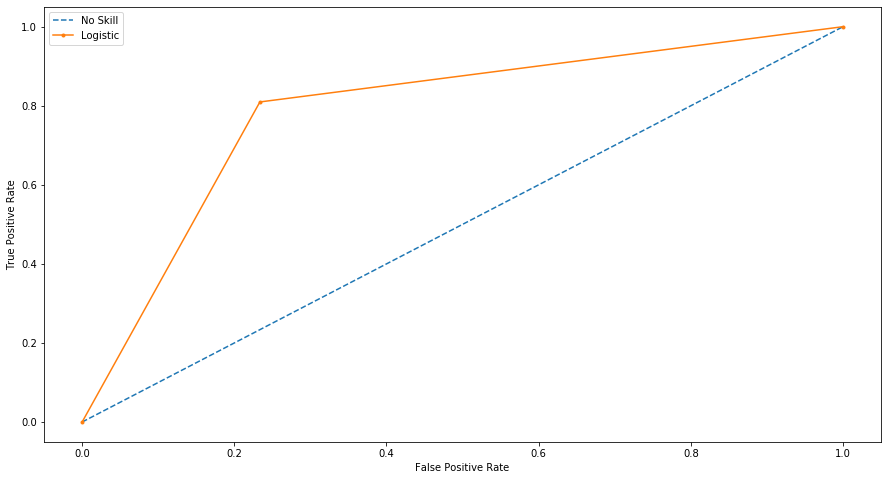

In [108]:
df = pca191_Ok.loc[:, ['RACE','PUMA', 'RELSHIPP', "AGEP", 'ESR', 'FER', 'JWMNP', 'JWTRNS', 'MIL', 'SCHL', 'SEX', "DIS",'HICOV', 'WKHP', 'ACCESS', 'ELEP', 'FULP', 'GASP', 'RNTP', 'WATP', 'PERNP', 'FS', 'FFSP', 'HINS4', 'PAP']].copy()
#Make new calculated column for dependent variable
df.loc[(df.FS == 1) | (df.FFSP == 1)| (df.HINS4 == 1) | (df.PAP > 0), "ASSISTANCE"] = 1
df.ASSISTANCE = df.ASSISTANCE.fillna(0)
#drop columns used to calculate predictor
df = df.drop(columns=['FS', 'FFSP', 'HINS4', 'PAP']).copy()

#Get rid of people not in the labor force and  people under 16
df = df.loc[(df.ESR != 6) & (df.AGEP >= 16)].copy()

df.FER = df.FER.fillna(2).copy()
df.JWMNP = df.JWMNP.fillna(0).copy()
df.WKHP = df.WKHP.fillna(0).copy()
df.RNTP = df.RNTP.fillna(0).copy()
df.WATP = df.WATP.fillna(0).copy()
df.MIL = df.MIL.fillna(4).copy()
df = df.loc[(df['ELEP'].notna()) & (df['JWTRNS'].notna())]
df = df.drop(columns=['FULP', 'GASP']).copy()

numericalCols = ['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']
catCols = ['RACE', 'PUMA', 'JWTRNS', 'MIL', 'SEX', 'SCHL', 'DIS', 'HICOV', 'ACCESS']

df = remOutliers(df, catCols, df.ASSISTANCE.name)

y = df["ASSISTANCE"]
X = df.drop(columns="ASSISTANCE")

# summarize class distribution
print(Counter(y))
o = 0.35
u = 1.0
# define oversampling strategy
over = RandomOverSampler(sampling_strategy=o)
# fit and apply the transform
X, y = over.fit_resample(X, y)
# summarize class distribution
print(Counter(y))
# define undersampling strategy
under = RandomUnderSampler(sampling_strategy=u)
# fit and apply the transform
X, y = under.fit_resample(X, y)
# summarize class distribution
print(Counter(y))

df = pd.concat([y,X], axis = 1, join = "inner")

numerical = df.loc[:,['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']].copy()
cat = df.loc[:,['PUMA', 'JWTRNS', 'MIL', 'SEX', 'SCHL', 'DIS', 'HICOV', 'ACESS']].copy()
for col in cat:
    cat[col] = cat[col].astype('category')
    
df_race = df.loc[:,'RACE']
df_cat = pd.get_dummies(cat, drop_first = True)
df_race = pd.get_dummies(df_race)
df = pd.concat([numerical, df_cat, df_race, y], axis = 1, join = "inner")

# split 60-40
df_train, df_test = train_test_split(df, train_size = 0.60, test_size = 0.40, random_state = 100, shuffle = True)

#rescale
scaler = MinMaxScaler()
nu_var = ['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']
df_train[nu_var] = scaler.fit_transform(df_train[nu_var])
#rescale testset
df_test[nu_var] = scaler.fit_transform(df_test[nu_var])
y_train = df_train.pop('ASSISTANCE')
X_train = df_train
y_test = df_test.pop('ASSISTANCE')
X_test = df_test

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(balanced_accuracy_score(y_test,y_pred))

ns_probs = [0 for _ in range(len(y_test))]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, y_pred)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred)

# plot the roc curve for the model
fig = plt.figure(figsize = (15,8))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

#### For presentation

In [113]:
coef = logreg.coef_.tolist()[0]
X_list = X_train.columns.tolist()
df_coef = pd.DataFrame(list(zip(X_list, coef)),
                    columns =['features', 'coefficients'])
df_coef['ABS'] = abs(df_coef.coefficients)
df_coef = df_coef.sort_values('ABS', ascending = False).reset_index(drop = True)
df_coef.drop(columns='ABS').head(10)

,features,coefficients
0,SCHL_10.0,-5.638711
1,MIL_3.0,-5.151150
2,SCHL_13.0,-5.132656
3,JWTRNS_6.0,-4.936675
4,SCHL_7.0,-4.302783
5,JWTRNS_8.0,-3.972172
6,SCHL_24.0,-3.495648
7,JWTRNS_5.0,-3.293346
8,PERNP,-3.140188
9,SCHL_21.0,-2.965642


In [114]:
df_coef[(df_coef.features == 'Asian') | (df_coef.features == 'African American') | (df_coef.features == 'White') | (df_coef.features == 'Latino')].drop(columns='ABS').sort_values('coefficients', ascending = False).reset_index(drop = True)

,features,coefficients
0,Asian,1.419469
1,African American,0.883272
2,White,0.613624
3,Latino,-0.411163


In [115]:
logreg.intercept_

array([2.89613189])

In [117]:
df = pca191_Ok.loc[:, ['RACE','PUMA', 'RELSHIPP', "AGEP", 'ESR', 'FER', 'JWMNP', 'JWTRNS', 'MIL', 'SCHL', 'SEX', "DIS",'HICOV', 'WKHP', 'ACCESS', 'ELEP', 'FULP', 'GASP', 'RNTP', 'WATP', 'PERNP', 'FS', 'FFSP', 'HINS4', 'PAP']].copy()
#Make new calculated column for dependent variable
df.loc[(df.FS == 1) | (df.FFSP == 1)| (df.HINS4 == 1) | (df.PAP > 0), "ASSISTANCE"] = 1
df.ASSISTANCE = df.ASSISTANCE.fillna(0)
#drop columns used to calculate predictor
df = df.drop(columns=['FS', 'FFSP', 'HINS4', 'PAP']).copy()

#Get rid of people not in the labor force and  people under 16
df = df.loc[(df.ESR != 6) & (df.AGEP >= 16)].copy()

df.FER = df.FER.fillna(2).copy()
df.JWMNP = df.JWMNP.fillna(0).copy()
df.WKHP = df.WKHP.fillna(0).copy()
df.RNTP = df.RNTP.fillna(0).copy()
df.WATP = df.WATP.fillna(0).copy()
df.MIL = df.MIL.fillna(4).copy()
df = df.loc[(df['ELEP'].notna()) & (df['JWTRNS'].notna())]
df = df.drop(columns=['FULP', 'GASP']).copy()

numericalCols = ['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']
catCols = ['RACE', 'PUMA', 'ESR', 'JWTRNS', 'FER', 'MIL', 'SEX', 'SCHL', 'DIS', 'HICOV', 'ACCESS']

df = remOutliers(df, catCols, df.ASSISTANCE.name)

y = df["ASSISTANCE"]
X = df.drop(columns="ASSISTANCE")

# summarize class distribution
print(Counter(y))
o = 0.35
u = 1.0
# define oversampling strategy
over = RandomOverSampler(sampling_strategy=o)
# fit and apply the transform
X, y = over.fit_resample(X, y)
# summarize class distribution
print(Counter(y))
# define undersampling strategy
under = RandomUnderSampler(sampling_strategy=u)
# fit and apply the transform
X, y = under.fit_resample(X, y)
# summarize class distribution
print(Counter(y))

df = pd.concat([y,X], axis = 1, join = "inner")

numerical = df.loc[:,['AGEP', 'JWMNP', 'WKHP', 'ELEP', 'RNTP', 'WATP', 'PERNP']].copy()

df = pd.concat([y, numerical], axis = 1, join = "inner")

Counter({0.0: 194867, 1.0: 11248})
Counter({0.0: 194867, 1.0: 68203})
Counter({0.0: 68203, 1.0: 68203})


In [118]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,ASSISTANCE,AGEP,JWMNP,WKHP,ELEP,RNTP,WATP,PERNP
ASSISTANCE,1,-0.085,-0.016,-0.082,0.087,0.074,0.092,-0.36
AGEP,-0.085,1,0.063,0.083,0.06,-0.24,0.076,0.14
JWMNP,-0.016,0.063,1,-0.075,0.036,-0.061,0.0074,0.079
WKHP,-0.082,0.083,-0.075,1,-0.014,0.11,-0.036,0.35
ELEP,0.087,0.06,0.036,-0.014,1,-0.21,0.19,-0.041
RNTP,0.074,-0.24,-0.061,0.11,-0.21,1,-0.13,-0.03
WATP,0.092,0.076,0.0074,-0.036,0.19,-0.13,1,-0.032
PERNP,-0.36,0.14,0.079,0.35,-0.041,-0.03,-0.032,1
